In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cf_units as cf
from geocat.viz import util as gvutil
from geocat.viz import cmaps as gvcmaps
import dask

In [2]:
def change_units(ds, variable_str, variable_bounds_str, target_unit_str):
    orig_units = cf.Unit(ds[variable_str].attrs['units'])
    target_units = cf.Unit(target_unit_str)
    variable_in_new_units = xr.apply_ufunc(
        orig_units.convert, ds[variable_bounds_str], target_units,
        output_dtypes=[ds[variable_bounds_str].dtype])
    return variable_in_new_units


def calculate_ohc(temperature, delta_z, z_t, z_str, z_limit):
    rho = 1026   # kg/m3
    c = 3900     # J/(kg K)
    delta_limit = delta_z.where(z_t < z_limit,drop=True)
    temperature_limit = temperature.where(z_t<z_limit, drop=True)
    print(temperature_limit.shape)
    weighted_temp= temperature_limit * delta_limit
    ohc = rho * c *  weighted_temp.sum(dim=z_str)
    return ohc

In [3]:
def accumulate_sum(array, n):
    sum_array = np.ones(n)
    for i in range(n):
        sum_array[i] = array[0:i+1].sum()        
    return xr.DataArray(data=sum_array, dims='time')
    

In [4]:
# usage: plot axes with cartopy in a panel plot 
# need to define figure before function

def map_contour_plots(variable, ncols, nrows, ax1, i, levels, colormap, title):

    variable = gvutil.xr_add_cyclic_longitudes(variable, "lon")

#    fig = plt.figure(figsize=(22, 15))
#    fig.tight_layout(pad=-2)

    ax1= plt.subplot(nrows, ncols, i, projection=ccrs.PlateCarree(central_longitude=180))
    ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    contour = variable.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=levels,
                           extend='both',
                            cmap = colormap,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)
    plt.colorbar(contour,
             ax=ax1,
             ticks=levels,
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



    gvutil.set_titles_and_labels(ax1,maintitle=title,
                             maintitlefontsize=20)
    gvutil.set_axes_limits_and_ticks(ax, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


    gvutil.add_major_minor_ticks(ax1, labelsize=12)


    gvutil.add_lat_lon_ticklabels(ax1)



#plt.show()



In [5]:
# map_contour_plots, example

#fig = plt.figure(figsize=(22, 15))
#fig.tight_layout(pad=-2)
#map_contour_plots(sfc_diff_ocn, 2, 2, ax, 1, np.arange(-4,4.5,0.5), cmocean.cm.balance,"title")
#map_contour_plots(sfc_diff_ocn,2,2,ax2, 2, np.arange(-5, 5.5, 0.5),cmocean.cm.balance,"title2")
#map_contour_plots(sfc_diff_ocn,2,2,ax3, 3, np.arange(-5, 5.5, 0.5),cmocean.cm.balance,"title3")


In [6]:
rearth  = 6.37122e6

In [7]:
from distributed.utils import format_bytes   # formate bytes into human readible units

In [8]:
# read in control
ds = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.ann.TEMP.0301-0400.nc")
temp0 = ds.TEMP

#read in dz and tarea
test = xr.open_dataset("/glade/scratch/huili7/archive/test_pe/ocn/hist/test_pe.pop.h.once.nc")
dz = test.dz
tarea = test.TAREA
temp0

<xarray.DataArray 'TEMP' (time: 100, z_t: 60, nlat: 384, nlon: 320)>
[737280000 values with dtype=float32]
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0400-02-01 00:00:00
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [9]:
format_bytes(ds.nbytes)  # xarray nbytes print out the data size

'2.95 GB'

In [10]:
# read TC run starting from year 301
case1 = "b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily"
ds_etc = xr.open_dataset("/glade/scratch/huili7/archive/"+case1+"/ocn/hist/"+case1+".pop.h.ann.TEMP.0301-0473.nc")
tempetc = ds_etc.TEMP
tempetc

<xarray.DataArray 'TEMP' (time: 173, z_t: 60, nlat: 384, nlon: 320)>
[1275494400 values with dtype=float32]
Coordinates:
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
  * time     (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

## Change untit and calculate OHC

In [11]:
zt_in_m = change_units(ds, "z_t", "z_t", "m")
dz_in_m = change_units(test,"dz","dz","m")
tarea_in_m2 = change_units(test,"TAREA","TAREA","m^2")

temp0_in_K = change_units(ds,"TEMP","TEMP","degK")

heat0= calculate_ohc(temp0_in_K, dz_in_m, zt_in_m, 'z_t',1000)
heat0_ann = heat0*tarea_in_m2
heat0_ann_g = heat0_ann.sum(('nlat','nlon'))      # Joule
heat0_ann_g

(100, 40, 384, 320)


<xarray.DataArray (time: 100)>
array([3.92331927e+26, 3.92335722e+26, 3.92332774e+26, 3.92332349e+26,
       3.92326668e+26, 3.92317237e+26, 3.92318179e+26, 3.92323670e+26,
       3.92323248e+26, 3.92318599e+26, 3.92310748e+26, 3.92312687e+26,
       3.92312951e+26, 3.92312574e+26, 3.92310495e+26, 3.92308541e+26,
       3.92316732e+26, 3.92320670e+26, 3.92321316e+26, 3.92322998e+26,
       3.92326559e+26, 3.92324959e+26, 3.92323816e+26, 3.92324768e+26,
       3.92326564e+26, 3.92325025e+26, 3.92326395e+26, 3.92324577e+26,
       3.92326051e+26, 3.92319082e+26, 3.92320626e+26, 3.92330688e+26,
       3.92329115e+26, 3.92333740e+26, 3.92331688e+26, 3.92327100e+26,
       3.92325892e+26, 3.92327516e+26, 3.92329739e+26, 3.92328674e+26,
       3.92330868e+26, 3.92334857e+26, 3.92326151e+26, 3.92320425e+26,
       3.92322103e+26, 3.92319150e+26, 3.92314711e+26, 3.92317136e+26,
       3.92321501e+26, 3.92325441e+26, 3.92328801e+26, 3.92332093e+26,
       3.92330788e+26, 3.92331610e+26, 3.92329192e+26, 3.92330492e+26,
       3.92332969e+26, 3.92337489e+26, 3.92340271e+26, 3.92343871e+26,
       3.92340855e+26, 3.92338700e+26, 3.92340442e+26, 3.92335706e+26,
       3.92336957e+26, 3.92340087e+26, 3.92335110e+26, 3.92337042e+26,
       3.92332851e+26, 3.92328522e+26, 3.92332785e+26, 3.92331489e+26,
       3.92326917e+26, 3.92324219e+26, 3.92321776e+26, 3.92323490e+26,
       3.92328609e+26, 3.92325680e+26, 3.92323066e+26, 3.92320476e+26,
       3.92320469e+26, 3.92321586e+26, 3.92325181e+26, 3.92320429e+26,
       3.92321387e+26, 3.92326679e+26, 3.92330954e+26, 3.92337496e+26,
       3.92337771e+26, 3.92340929e+26, 3.92341471e+26, 3.92343297e+26,
       3.92342872e+26, 3.92337098e+26, 3.92330697e+26, 3.92330191e+26,
       3.92329696e+26, 3.92330581e+26, 3.92324857e+26, 3.92322417e+26])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0400-02-01 00:00:00

In [12]:
# tc 301

temp_etc_in_K = change_units(ds_etc,"TEMP","TEMP","degK")
heat_etc = calculate_ohc(temp_etc_in_K, dz_in_m, zt_in_m,'z_t',1000)
heat_etc_ann = heat_etc*tarea_in_m2
heat_etc_ann_g = heat_etc_ann.sum(('nlat','nlon')) 

(173, 40, 384, 320)


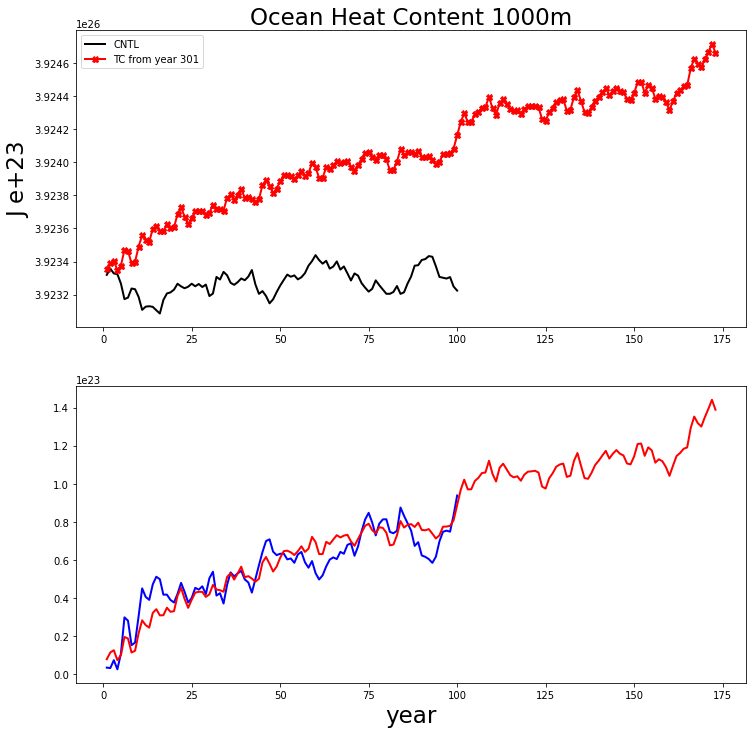

In [13]:
fig, [ax0,ax1] = plt.subplots(2,1,figsize=(12,12))
ax0.plot(np.arange(1,101,1),heat0_ann_g[0:100],color='black',linewidth=2,label='CNTL')
ax0.plot(np.arange(1,174,1),heat_etc_ann_g,linewidth=2.,color='red',marker='X',label='TC from year 301')


ax0.set_title('Ocean Heat Content 1000m',fontsize=23)
ax0.set_ylabel('J e+23',fontsize=23)
ax1.set_xlabel('year',fontsize=23)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels)

cntl_mean = heat0_ann_g.mean()

ohc_diff = heat_etc_ann_g[0:100].copy(data=(heat_etc_ann_g[0:100].data - heat0_ann_g.data))
ohc_diff2 = heat_etc_ann_g.copy(data=(heat_etc_ann_g.data-cntl_mean.data))
ax1.plot(np.arange(1,101,step=1),ohc_diff,color='blue',linewidth=2,label='ohc_diff')
ax1.plot(np.arange(1,174,step=1),ohc_diff2,color='red',linewidth=2,label='ohc_diff')

#ax1.set_title('OHC diff (TC 301 - CNTL)',fontsize=23)
#ax1.set_ylabel('J',fontsize=23)
#print(heat0_ann_g.mean('time'))

plt.savefig("new_ohc.png")

## now calculate OHC below seasonal maximum mixed layer depth. the mixed layder depth is based on the control simulation

In [14]:
dsxh0 = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.monclm.nc')
xmxl0 = change_units(dsxh0,'XMXL','XMXL','m')


In [15]:
zt_xmxl0 = xmxl0.max(dim='time')


In [16]:
deep_temp = temp_etc_in_K.where(zt_in_m > zt_xmxl0)
deep_temp0 = temp0_in_K.where(zt_in_m>zt_xmxl0)

In [17]:
heat0x= calculate_ohc(deep_temp0, dz_in_m, zt_in_m, 'z_t',1000)
heat0x_ann = heat0x*tarea_in_m2
heat0x_ann_g = heat0x_ann.sum(('nlat','nlon'))      # Joule
heat0x_ann_g

(100, 40, 384, 320)


<xarray.DataArray (time: 100)>
array([3.34670070e+26, 3.34667821e+26, 3.34657666e+26, 3.34654643e+26,
       3.34657480e+26, 3.34664534e+26, 3.34669699e+26, 3.34665445e+26,
       3.34662308e+26, 3.34653223e+26, 3.34661875e+26, 3.34663554e+26,
       3.34652206e+26, 3.34647914e+26, 3.34656641e+26, 3.34667976e+26,
       3.34666972e+26, 3.34656541e+26, 3.34662509e+26, 3.34667544e+26,
       3.34664915e+26, 3.34658524e+26, 3.34665207e+26, 3.34665405e+26,
       3.34660445e+26, 3.34660853e+26, 3.34664910e+26, 3.34664736e+26,
       3.34661529e+26, 3.34668156e+26, 3.34672640e+26, 3.34669330e+26,
       3.34668508e+26, 3.34672418e+26, 3.34667705e+26, 3.34675338e+26,
       3.34684243e+26, 3.34674406e+26, 3.34661242e+26, 3.34668987e+26,
       3.34672559e+26, 3.34663781e+26, 3.34658468e+26, 3.34654565e+26,
       3.34651260e+26, 3.34651303e+26, 3.34656555e+26, 3.34662163e+26,
       3.34653802e+26, 3.34652447e+26, 3.34660447e+26, 3.34663610e+26,
       3.34664739e+26, 3.34662202e+26, 3.34664855e+26, 3.34667481e+26,
       3.34666753e+26, 3.34667080e+26, 3.34667625e+26, 3.34670613e+26,
       3.34676120e+26, 3.34678360e+26, 3.34671172e+26, 3.34681429e+26,
       3.34684651e+26, 3.34671890e+26, 3.34666363e+26, 3.34663025e+26,
       3.34662360e+26, 3.34668866e+26, 3.34667847e+26, 3.34658254e+26,
       3.34660765e+26, 3.34664675e+26, 3.34659765e+26, 3.34653285e+26,
       3.34651506e+26, 3.34647246e+26, 3.34653490e+26, 3.34656671e+26,
       3.34656729e+26, 3.34655773e+26, 3.34647904e+26, 3.34652067e+26,
       3.34658338e+26, 3.34657894e+26, 3.34660410e+26, 3.34665215e+26,
       3.34667225e+26, 3.34668620e+26, 3.34668220e+26, 3.34669139e+26,
       3.34668023e+26, 3.34666249e+26, 3.34667575e+26, 3.34671280e+26,
       3.34677443e+26, 3.34674378e+26, 3.34666645e+26, 3.34673916e+26])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0400-02-01 00:00:00

In [18]:
heatx = calculate_ohc(deep_temp,dz_in_m, zt_in_m,'z_t',1000)
heatx_ann = heatx *tarea_in_m2
heatx_ann_g = heatx_ann.sum(('nlat','nlon'))
heatx_ann_g

(173, 40, 384, 320)


<xarray.DataArray (time: 173)>
array([3.34665672e+26, 3.34663516e+26, 3.34660510e+26, 3.34666531e+26,
       3.34674366e+26, 3.34665322e+26, 3.34659993e+26, 3.34671748e+26,
       3.34682066e+26, 3.34678635e+26, 3.34672536e+26, 3.34673885e+26,
       3.34681738e+26, 3.34681372e+26, 3.34675875e+26, 3.34670231e+26,
       3.34682326e+26, 3.34682403e+26, 3.34680241e+26, 3.34690188e+26,
       3.34686858e+26, 3.34677117e+26, 3.34677989e+26, 3.34687315e+26,
       3.34693296e+26, 3.34689110e+26, 3.34688977e+26, 3.34694031e+26,
       3.34703383e+26, 3.34706339e+26, 3.34699724e+26, 3.34694857e+26,
       3.34694627e+26, 3.34697913e+26, 3.34699588e+26, 3.34693263e+26,
       3.34699850e+26, 3.34703672e+26, 3.34703876e+26, 3.34704965e+26,
       3.34695921e+26, 3.34694269e+26, 3.34701398e+26, 3.34705164e+26,
       3.34704979e+26, 3.34701545e+26, 3.34703103e+26, 3.34705499e+26,
       3.34710914e+26, 3.34710541e+26, 3.34702083e+26, 3.34704472e+26,
       3.34705191e+26, 3.34712562e+26, 3.34716493e+26, 3.34707921e+26,
       3.34712540e+26, 3.34719551e+26, 3.34716930e+26, 3.34711028e+26,
       3.34722074e+26, 3.34726685e+26, 3.34719893e+26, 3.34718404e+26,
       3.34714780e+26, 3.34707257e+26, 3.34712048e+26, 3.34719461e+26,
       3.34709789e+26, 3.34708872e+26, 3.34721678e+26, 3.34726074e+26,
       3.34730412e+26, 3.34731841e+26, 3.34722069e+26, 3.34722862e+26,
       3.34733504e+26, 3.34732585e+26, 3.34720373e+26, 3.34715751e+26,
       3.34727964e+26, 3.34743606e+26, 3.34746346e+26, 3.34739002e+26,
       3.34737231e+26, 3.34740181e+26, 3.34742148e+26, 3.34743637e+26,
       3.34741217e+26, 3.34738254e+26, 3.34739309e+26, 3.34731839e+26,
       3.34726832e+26, 3.34728211e+26, 3.34734894e+26, 3.34731517e+26,
       3.34730487e+26, 3.34738489e+26, 3.34740403e+26, 3.34738114e+26,
       3.34736956e+26, 3.34736278e+26, 3.34738458e+26, 3.34744736e+26,
       3.34743666e+26, 3.34742738e+26, 3.34746645e+26, 3.34749709e+26,
       3.34743829e+26, 3.34749481e+26, 3.34764576e+26, 3.34763871e+26,
       3.34756144e+26, 3.34750388e+26, 3.34756559e+26, 3.34761526e+26,
       3.34759196e+26, 3.34757375e+26, 3.34752113e+26, 3.34749001e+26,
       3.34757552e+26, 3.34757203e+26, 3.34754438e+26, 3.34757187e+26,
       3.34753858e+26, 3.34744094e+26, 3.34749223e+26, 3.34756290e+26,
       3.34749105e+26, 3.34742436e+26, 3.34751068e+26, 3.34757105e+26,
       3.34752856e+26, 3.34751404e+26, 3.34746315e+26, 3.34748663e+26,
       3.34755624e+26, 3.34756222e+26, 3.34754730e+26, 3.34752370e+26,
       3.34757065e+26, 3.34756491e+26, 3.34754505e+26, 3.34758260e+26,
       3.34758102e+26, 3.34751424e+26, 3.34747365e+26, 3.34754849e+26,
       3.34764217e+26, 3.34768044e+26, 3.34762271e+26, 3.34763795e+26,
       3.34763151e+26, 3.34756165e+26, 3.34760968e+26, 3.34773581e+26,
       3.34778310e+26, 3.34771773e+26, 3.34767218e+26, 3.34770111e+26,
       3.34772004e+26, 3.34764562e+26, 3.34758599e+26, 3.34769114e+26,
       3.34775754e+26, 3.34777992e+26, 3.34774931e+26, 3.34774610e+26,
       3.34779647e+26, 3.34773197e+26, 3.34775636e+26, 3.34771296e+26,
       3.34766115e+26])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00

In [36]:
ohc_diffx = heatx_ann_g.copy(data=(heatx_ann_g.data-heat0x_ann_g.mean('time').data))


# Now the atmosphere 

In [19]:
del ds_etc

In [20]:
tmp_dataset= xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/atm/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.cam.h0.0331-01.nc')
area = tmp_dataset.area
area = area * rearth**2        # convert radian square area to m2
oceanfrac = tmp_dataset.OCNFRAC
lat = tmp_dataset.lat
lon = tmp_dataset.lon

In [21]:
tmp_dataset

<xarray.Dataset>
Dimensions:        (ilev: 31, lev: 30, nbnd: 2, ncol: 48602, time: 1)
Coordinates:
  * lev            (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev           (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time           (time) object 0331-02-01 00:00:00
Dimensions without coordinates: nbnd, ncol
Data variables:
    hyam           (lev) float64 ...
    hybm           (lev) float64 ...
    P0             float64 ...
    hyai           (ilev) float64 ...
    hybi           (ilev) float64 ...
    date           (time) int32 ...
    datesec        (time) int32 ...
    lat            (ncol) float64 ...
    area           (ncol) float64 4.397e-05 0.0001465 ... 0.0003665 0.0003665
    lon            (ncol) float64 ...
    time_bnds      (time, nbnd) object ...
    date_written   (time) |S8 ...
    time_written   (time) |S8 ...
    ntrm           int32 ...
    ntrn           int32 ...
    ntrk           int32 ...
    ndbase         int32 ...
    nsbase         int32 ...
    nbdate         int32 ...
    nbsec          int32 ...
    mdt            int32 ...
    ndcur          (time) int32 ...
    nscur          (time) int32 ...
    co2vmr         (time) float64 ...
    ch4vmr         (time) float64 ...
    n2ovmr         (time) float64 ...
    f11vmr         (time) float64 ...
    f12vmr         (time) float64 ...
    sol_tsi        (time) float64 ...
    nsteph         (time) int32 ...
    AEROD_v        (time, ncol) float32 ...
    ANRAIN         (time, lev, ncol) float32 ...
    ANSNOW         (time, lev, ncol) float32 ...
    AODDUST1       (time, ncol) float32 ...
    AODDUST3       (time, ncol) float32 ...
    AODVIS         (time, ncol) float32 ...
    AQRAIN         (time, lev, ncol) float32 ...
    AQSNOW         (time, lev, ncol) float32 ...
    AREI           (time, lev, ncol) float32 ...
    AREL           (time, lev, ncol) float32 ...
    AWNC           (time, lev, ncol) float32 ...
    AWNI           (time, lev, ncol) float32 ...
    BURDEN1        (time, ncol) float32 ...
    BURDEN2        (time, ncol) float32 ...
    BURDEN3        (time, ncol) float32 ...
    BURDENBC       (time, ncol) float32 ...
    BURDENDUST     (time, ncol) float32 ...
    BURDENPOM      (time, ncol) float32 ...
    BURDENSEASALT  (time, ncol) float32 ...
    BURDENSO4      (time, ncol) float32 ...
    BURDENSOA      (time, ncol) float32 ...
    CCN3           (time, lev, ncol) float32 ...
    CDNUMC         (time, ncol) float32 ...
    CLDHGH         (time, ncol) float32 ...
    CLDICE         (time, lev, ncol) float32 ...
    CLDLIQ         (time, lev, ncol) float32 ...
    CLDLOW         (time, ncol) float32 ...
    CLDMED         (time, ncol) float32 ...
    CLDTOT         (time, ncol) float32 ...
    CLOUD          (time, lev, ncol) float32 ...
    DCQ            (time, lev, ncol) float32 ...
    DMS_SRF        (time, ncol) float32 ...
    DTCOND         (time, lev, ncol) float32 ...
    DTV            (time, lev, ncol) float32 ...
    DTWR_H2O2      (time, lev, ncol) float32 ...
    DTWR_H2SO4     (time, lev, ncol) float32 ...
    DTWR_SO2       (time, lev, ncol) float32 ...
    EMISCLD        (time, lev, ncol) float32 ...
    FICE           (time, lev, ncol) float32 ...
    FLDS           (time, ncol) float32 ...
    FLNS           (time, ncol) float32 ...
    FLNSC          (time, ncol) float32 ...
    FLNT           (time, ncol) float32 ...
    FLNTC          (time, ncol) float32 ...
    FLUT           (time, ncol) float32 ...
    FLUTC          (time, ncol) float32 ...
    FREQI          (time, lev, ncol) float32 ...
    FREQL          (time, lev, ncol) float32 ...
    FREQR          (time, lev, ncol) float32 ...
    FREQS          (time, lev, ncol) float32 ...
    FSDS           (time, ncol) float32 ...
    FSDSC          (time, ncol) float32 ...
    FSNS           (time, ncol) float32 ...
    FSNSC          (time, ncol) float32 ...
    FSNT           (time, ncol) float32 ...
   

## read in data

In [22]:
dsa = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/atm/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.cam.h0.ann.radi.0301-0400.nc")

flnt = dsa.FLNT
fsnt = dsa.FSNT
fsns = dsa.FSNS
flns = dsa.FLNS
shflx = dsa.SHFLX
lhflx = dsa.LHFLX
toa = flnt.copy(data=(fsnt.data-flnt.data))
sfc = fsns.copy(data=(fsns.data-flns.data))

ressfc = sfc.copy(data=(sfc.data-shflx.data-lhflx.data))  #residual surface fluxes

In [23]:
ds2 = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/atm/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.cam.h0.radi.ann.0301-0473.nc')
flnt2 = ds2.FLNT
fsnt2 = ds2.FSNT
fsns2 = ds2.FSNS
flns2 = ds2.FLNS
shflx2 = ds2.SHFLX
lhflx2 = ds2.LHFLX
toa2 = flnt2.copy(data=(fsnt2.data-flnt2.data))
sfc2 = fsns2.copy(data=(fsns2.data-flns2.data))

ressfc2 = sfc2.copy(data=(sfc2.data-shflx2.data-lhflx2.data))

In [24]:
ntime0 = ressfc.shape[0]
ntime2 = ressfc2.shape[0]

## get radiative energy into the ocean fraction

In [25]:
oceanfrac_3d = ressfc.copy(data=np.repeat(oceanfrac,ntime0, axis=0))
oceanfrac_3d

oceanfrac_3d2 = ressfc2.copy(data=np.repeat(oceanfrac,ntime2, axis=0))
oceanfrac_3d2


<xarray.DataArray 'FSNS' (time: 173, ncol: 48602)>
array([[1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031],
       [1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031],
       [1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031],
       ...,
       [1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031],
       [1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031],
       [1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031]], dtype=float32)
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Net solar flux at surface
    cell_methods:       time: mean

In [26]:
fsns_ocean = fsns * oceanfrac_3d
flns_ocean = flns * oceanfrac_3d

fsns_ocean2 = fsns2 * oceanfrac_3d2
flns_ocean2 = flns2 * oceanfrac_3d2

res_ocean = ressfc * oceanfrac_3d
res_ocean2 = ressfc2 * oceanfrac_3d2

sfc_ocean = sfc * oceanfrac_3d
sfc_ocean2 = sfc2 * oceanfrac_3d2

lhf_ocean = lhflx * oceanfrac_3d
lhf_ocean2 = lhflx2 * oceanfrac_3d2

shf_ocean = shflx * oceanfrac_3d
shf_ocean2 = shflx2 * oceanfrac_3d2

toa_ocean = toa * oceanfrac_3d
toa_ocean2 = toa2* oceanfrac_3d2
## for TOA, we don't really need to get ocean fraction

## plot residual energy from the atmosphere

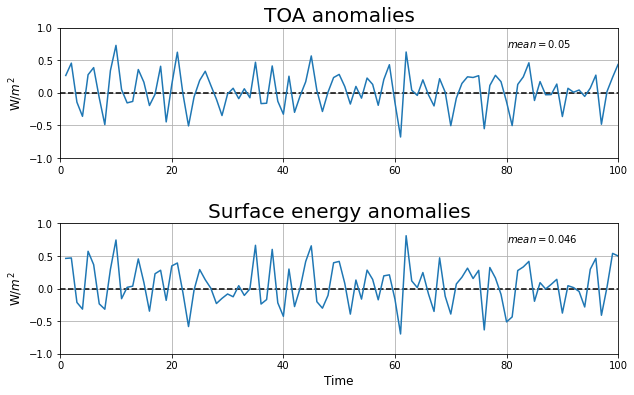

In [27]:
fig, [ax0,ax1] = plt.subplots(2,1,figsize=(10,6))
fig.subplots_adjust(hspace=0.5)
#ax0.plot(res_ocean.time[0:100],res_ocean[0:100].weighted(area).sum('ncol'),color='black',label='CNTL')
#ax0.plot(res_ocean2.time,res_ocean2.weighted(area).sum('ncol'),color='red',label='TC')

toa_diff = toa_ocean2.copy(data=(toa_ocean2.data - toa_ocean.mean('time').data))
res_diff = res_ocean2.copy(data=(res_ocean2.data - res_ocean.mean('time').data))


ax0.plot(np.arange(0, 176, 1),np.zeros(176), color="black", linestyle='--', lw=1.5)
ax0.plot(np.arange(1, 174,1),toa_diff.weighted(area).mean('ncol'))
ax1.plot(np.arange(0, 176, 1),np.zeros(176), color="black", linestyle='--', lw=1.5)
ax1.plot(np.arange(1, 174, 1), res_diff.weighted(area).mean('ncol'))

ax0.set_title("TOA anomalies", fontsize=20)
ax0.set_ylim(-1.,1.)
ax0.set_xlim(0,100)
ax0.set_ylabel('W/$m^2$', fontsize=12)
ax0.grid(True)
ax0.text(80, .7, '$mean=0.05$ ')

ax1.set_title("Surface energy anomalies", fontsize=20)
ax1.set_ylabel("W/$m^2$", fontsize=12)
ax1.set_ylim(-1., 1.)
ax1.set_xlim(0,100)
ax1.text(80, .7, '$mean=0.046$ ')

ax1.grid(True)
ax1.set_xlabel("Time", fontsize=12)
plt.savefig("atm_energy_series.pdf")

In [28]:
toa_diff.weighted(area).mean(('ncol','time'))

<xarray.DataArray ()>
array(0.05035563)

In [29]:
res_diff.weighted(area).mean(('ncol','time'))

<xarray.DataArray ()>
array(0.04594806)

## Accumulated surface energy residual and comprison with ocean heat content

In [30]:
res_series = res_ocean2.weighted(area).sum('ncol') - res_ocean.weighted(area).sum('ncol').mean()
res_series = res_series * 365* 24 * 3600   # w to J
res_total = accumulate_sum(res_series,173)

In [31]:
toa_series = toa_ocean2.weighted(area).sum('ncol') - toa_ocean.weighted(area).sum('ncol').mean()
toa_series = toa_series * 365* 24 * 3600   # w to J
toa_total = accumulate_sum(toa_series, 173)

In [32]:
res_series0 = res_ocean2[0:100].weighted(area).sum('ncol') - res_ocean.weighted(area).sum('ncol')
res_series0 = res_series0 * 365* 24 * 3600   # w to J
res_total0 = accumulate_sum(res_series0,100)

In [33]:
res_total.rolling(time=10, center=True).mean()

<xarray.DataArray (time: 173)>
array([           nan,            nan,            nan,            nan,
                  nan, 1.55185913e+22, 1.74665812e+22, 1.86901981e+22,
       2.03151137e+22, 2.31785974e+22, 2.52734207e+22, 2.62219558e+22,
       2.79130086e+22, 3.05652151e+22, 3.24552905e+22, 3.37061415e+22,
       3.58372770e+22, 3.78356640e+22, 3.88378921e+22, 3.90775992e+22,
       3.96351062e+22, 4.09668864e+22, 4.19416874e+22, 4.20955784e+22,
       4.22982360e+22, 4.18088804e+22, 4.04869056e+22, 3.93387177e+22,
       3.89585763e+22, 3.86018252e+22, 3.88438748e+22, 3.84862823e+22,
       3.78498471e+22, 3.85483360e+22, 3.91368399e+22, 3.91740719e+22,
       3.98948247e+22, 4.01001619e+22, 4.04835757e+22, 4.15418919e+22,
       4.25869124e+22, 4.36901775e+22, 4.45802654e+22, 4.43369255e+22,
       4.50813022e+22, 4.71807366e+22, 4.89291080e+22, 5.04916919e+22,
       5.22549740e+22, 5.30911999e+22, 5.33286310e+22, 5.41152850e+22,
       5.51083228e+22, 5.65821698e+22, 5.77588140e+22, 5.80002586e+22,
       5.69918663e+22, 5.79168052e+22, 5.88212950e+22, 6.00088418e+22,
       6.11364877e+22, 6.19081681e+22, 6.23934505e+22, 6.33234622e+22,
       6.37253689e+22, 6.37641551e+22, 6.50358642e+22, 6.52844399e+22,
       6.58467192e+22, 6.66331900e+22, 6.74738426e+22, 6.74261304e+22,
       6.84615693e+22, 6.89993917e+22, 6.95851827e+22, 6.99768033e+22,
       6.95562235e+22, 6.92993235e+22, 6.90728784e+22, 6.92689863e+22,
       6.87024141e+22, 6.93006678e+22, 6.93689575e+22, 6.92809853e+22,
       6.95626578e+22, 7.00618890e+22, 7.13307118e+22, 7.21794446e+22,
       7.24216439e+22, 7.15396753e+22, 7.14478428e+22, 7.19547656e+22,
       7.18140285e+22, 7.16043964e+22, 7.20345329e+22, 7.38729074e+22,
       7.61277011e+22, 7.84720066e+22, 8.02360842e+22, 8.27073900e+22,
       8.48454011e+22, 8.64691616e+22, 8.86928494e+22, 9.13905502e+22,
       9.28275935e+22, 9.23554058e+22, 9.22755686e+22, 9.25022511e+22,
       9.34836211e+22, 9.35758487e+22, 9.33766787e+22, 9.29976458e+22,
       9.24313138e+22, 9.16577962e+22, 9.19682328e+22, 9.30338435e+22,
       9.32683044e+22, 9.32439575e+22, 9.26525159e+22, 9.19513997e+22,
       9.21222949e+22, 9.24187028e+22, 9.26714855e+22, 9.33026949e+22,
       9.33706682e+22, 9.33497585e+22, 9.24939791e+22, 9.24470412e+22,
       9.33492601e+22, 9.52476826e+22, 9.54140419e+22, 9.48530737e+22,
       9.48720416e+22, 9.44808296e+22, 9.44730483e+22, 9.50727527e+22,
       9.66351223e+22, 9.74899821e+22, 9.70805749e+22, 9.64824785e+22,
       9.76882561e+22, 9.87401957e+22, 9.92891115e+22, 9.91896480e+22,
       9.85968947e+22, 9.87817249e+22, 9.88393322e+22, 9.85516141e+22,
       9.94042866e+22, 1.00173660e+23, 9.95306076e+22, 9.90206610e+22,
       9.97090655e+22, 1.00453429e+23, 1.00682859e+23, 1.00191759e+23,
       1.00097872e+23, 1.00480288e+23, 1.00935988e+23, 1.01028361e+23,
       1.02533050e+23, 1.05631661e+23, 1.07670931e+23, 1.09709911e+23,
       1.12774833e+23, 1.16074602e+23, 1.19067183e+23, 1.21744073e+23,
       1.23542758e+23,            nan,            nan,            nan,
                  nan])
Dimensions without coordinates: time

## difference between OHC and residual total -- at the end, there are two spikes at 330 and 400. 

## surface residual mainly come from?

In [34]:
sfc_series = sfc_ocean2.weighted(area).sum('ncol') - sfc_ocean.weighted(area).sum('ncol').mean()
sfc_series = sfc_series * 365* 24 * 3600   # w to J
sfc_total = accumulate_sum(sfc_series,173)

lhf_series = lhf_ocean2.weighted(area).sum('ncol') - lhf_ocean.weighted(area).sum('ncol').mean()
lhf_series = lhf_series * 365* 24 * 3600   # w to J
lhf_total = accumulate_sum(lhf_series,173)

shf_series = shf_ocean2.weighted(area).sum('ncol') - shf_ocean.weighted(area).sum('ncol').mean()
shf_series = shf_series * 365* 24 * 3600   # w to J
shf_total = accumulate_sum(shf_series,173)


In [26]:
print(lhf_series[30:173].mean('time'))
print(sfc_series[30:173].mean('time'))

<xarray.DataArray ()>
array(1.6284036e+21)
<xarray.DataArray ()>
array(1.90541127e+21)


Text(0.5, 1.0, 'energy compare')

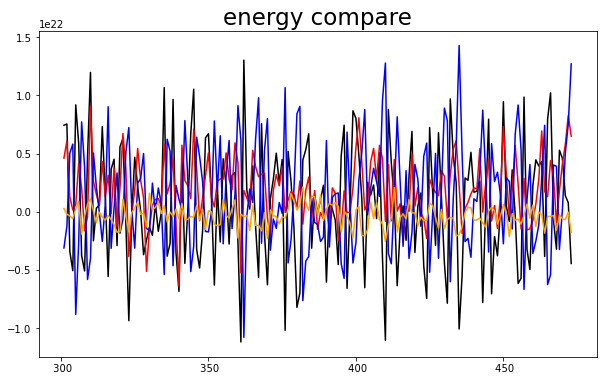

In [27]:
fig, ax0 = plt.subplots(figsize=(10,6))
ax0.plot(res_series.time[0:173],res_series[0:173],color='black',label='atm res')
ax0.plot(sfc_series.time[0:173],sfc_series[0:173],color='red',label='sfc radi')
ax0.plot(lhf_series.time[0:173],lhf_series[0:173],color='blue',label='lhf')
ax0.plot(shf_series.time[0:173],shf_series[0:173],color='orange',label='shf')

ax0.set_title("energy compare",fontsize=23)

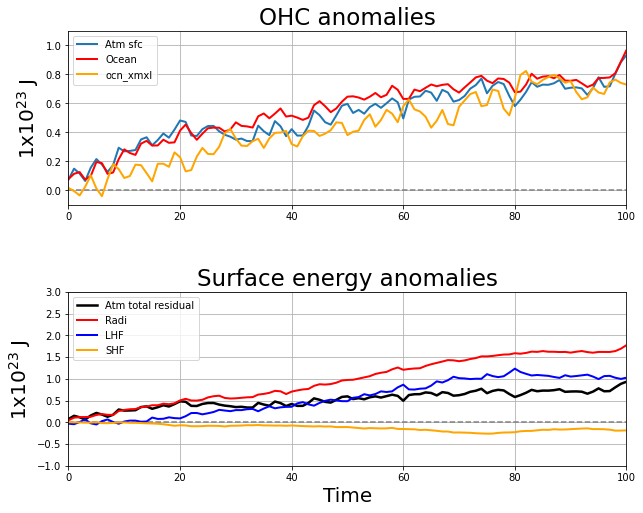

In [40]:

fig, [ax0,ax1] = plt.subplots(2,1,figsize=(10,8))
fig.subplots_adjust(hspace=0.5)

ax0.plot(np.arange(0, 173, 1),np.zeros(173), color="grey", linestyle='--', lw=1.5)
ax0.plot(res_total.time[0:173],res_total[0:173]*1e-23,lw=2,label='Atm sfc')
ax0.plot(np.arange(0,173,step=1),ohc_diff2[0:173]*1e-23,color='red',lw=2,label='Ocean')
ax0.plot(np.arange(0,173,step=1), ohc_diffx[0:173]*1e-23,color="orange",lw=2, label='ocn_xmxl')
ax0.set_title("OHC anomalies",fontsize=23)

handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels)
ax0.grid(True)
ax0.set_ylim(-0.1,1.1)
ax0.set_ylabel('1x$10^{23}$ J',fontsize=20)
ax0.set_xlim(0, 100)
#net = ohc_diff2[0:173] - res_total
#ax1.plot(net[0:173].time, net[0:173])
#ax1.set_title('ohc-res',fontsize=23)
#ax1.set_ylim(0, 2e23)

ax1.plot(np.arange(0, 173, 1),np.zeros(173), color="grey", linestyle='--', lw=1.5)
ax1.plot(res_total.time[0:173],res_total[0:173]* 1e-23,color='black', lw=2.5,label='Atm total residual')
ax1.plot(sfc_total.time[0:173],sfc_total[0:173]* 1e-23,color='red',lw=2,label='Radi')
ax1.plot(lhf_total.time[0:173],lhf_total[0:173]* 1e-23,color='blue',lw=2,label='LHF')
ax1.plot(shf_total.time[0:173],shf_total[0:173]* 1e-23,color='orange',lw=2,label='SHF')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)

ax1.set_title("Surface energy anomalies",fontsize=23)
ax1.grid(True)
ax1.set_xlim(0, 100)
ax1.set_ylim(-1, 3.)
ax1.set_ylabel('1x$10^{23}$ J',fontsize=20)
ax1.set_xlabel('Time',fontsize=20)
plt.savefig("ohc_atmres_series.pdf")


### So, surface residual energy is dominated by increased radiative heating, secondly by latent heating, and reduced sensible heating. both radiative heating and latent heating contribute to the spike at year 100. What happens at year 100?

# focus on radiative balance use regridded data to plot maps

In [24]:
dsregrid = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.sehires24_CNTL_010.cam.h0.ann.radi.0331-0400.nc')
rlhflx = dsregrid.LHFLX
rfsns = dsregrid.FSNS
rflns = dsregrid.FLNS
rshflx = dsregrid.SHFLX

In [25]:
ddregrid = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.cam.h0.ann.radi.0301-0473.nc')
ddregrid
rlhflx2 = ddregrid.LHFLX
rfsns2 = ddregrid.FSNS
rflns2 = ddregrid.FLNS
rshflx2 = ddregrid.SHFLX

In [26]:
regrid_shf_diff = rshflx[0,:,:].copy(data=rshflx2[70:100].mean('time').data - rshflx.mean('time').data)
regrid_lhf_diff = rlhflx[0,:,:].copy(data=rlhflx2[70:100].mean('time').data - rlhflx.mean('time').data)
regrid_fsns_diff = rfsns[0,:,:].copy(data=rfsns2[70:100].mean('time').data - rfsns.mean('time').data)
regrid_flns_diff = rflns[0,:,:].copy(data=rflns2[70:100].mean('time').data - rflns.mean('time').data)
regrid_sfc_diff = regrid_flns_diff.copy(data=regrid_fsns_diff.data - regrid_flns_diff.data)

In [27]:
dg = xr.open_dataset('regrid_cam_ocnfrac.nc')
ocnfrac = dg.OCNFRAC

sfc_diff_ocn = regrid_sfc_diff * ocnfrac[0,:,:]
lhf_diff_ocn = regrid_lhf_diff * ocnfrac[0,:,:]
shf_diff_ocn = regrid_shf_diff * ocnfrac[0,:,:]

total_diff_ocn = shf_diff_ocn.copy(data=(sfc_diff_ocn.data - lhf_diff_ocn.data - shf_diff_ocn.data))


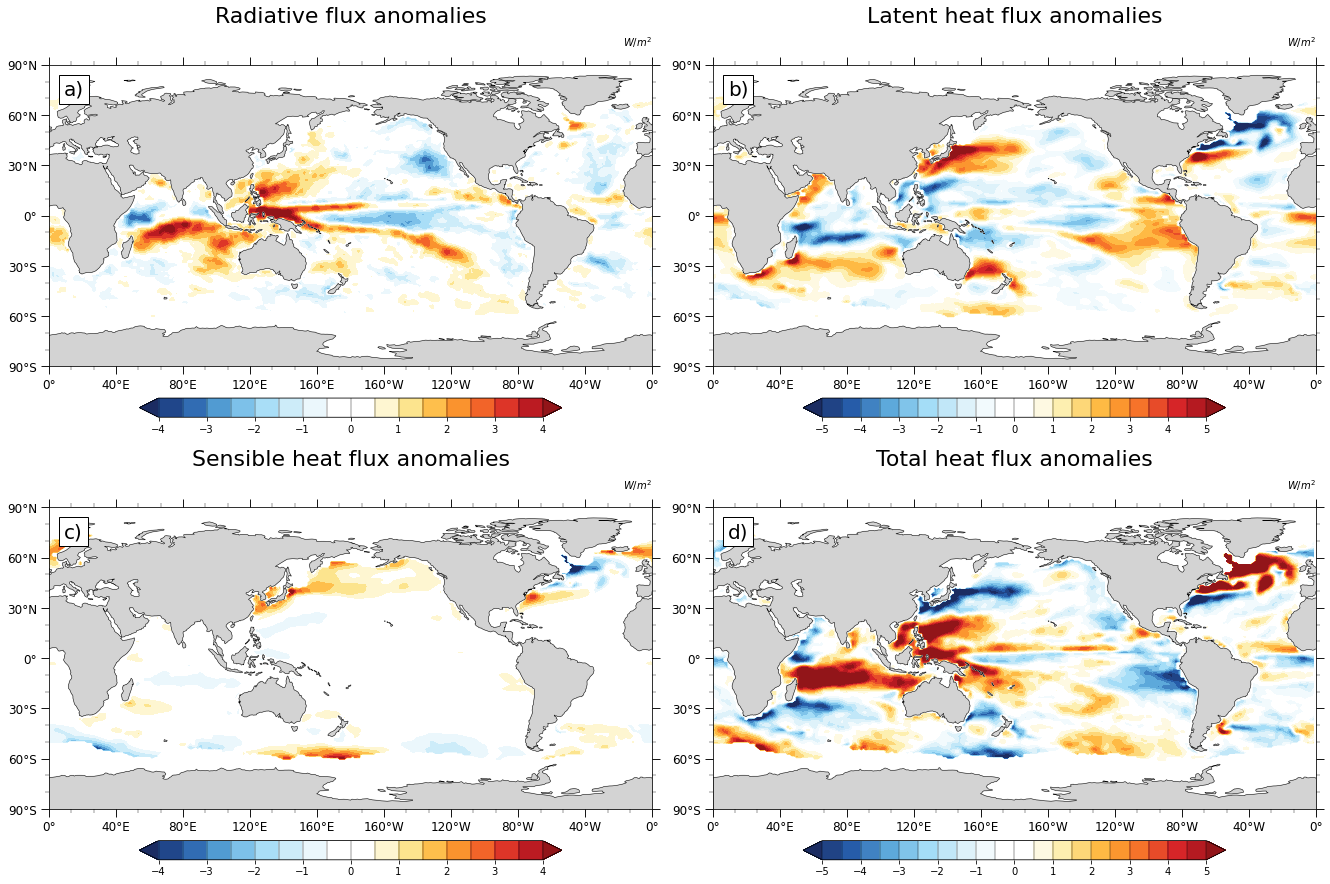

In [29]:
sfc_diff_ocn = gvutil.xr_add_cyclic_longitudes(sfc_diff_ocn, "lon")
lhf_diff_ocn = gvutil.xr_add_cyclic_longitudes(lhf_diff_ocn, "lon")
shf_diff_ocn = gvutil.xr_add_cyclic_longitudes(shf_diff_ocn, "lon")


fig = plt.figure(figsize=(22, 15))
fig.tight_layout(pad=-2)

#grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[0.85, 0.15],wspace=0.08)
#map_contour_plots(sfc_diff_ocn,2, 2, ax, 1, np.arange(-4,4.5,0.5), gvcmaps.BlueWhiteOrangeRed, "Radiative flux anomalies", "$W/m^2$")

ax = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
contour = sfc_diff_ocn.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-4, 4.5, 0.5),
                           extend='both',
                            cmap = gvcmaps.BlueWhiteOrangeRed,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)
plt.colorbar(contour,
             ax=ax,
             ticks=np.linspace(-6, 6, 13),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax,maintitle="Radiative flux anomalies",
                             maintitlefontsize=20,righttitle="$W/m^2$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


gvutil.add_major_minor_ticks(ax, labelsize=12)


gvutil.add_lat_lon_ticklabels(ax)

#----
ax1 = plt.subplot(2,2,2, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour1 = lhf_diff_ocn.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-5, 5.5, 0.5),
                           cmap = gvcmaps.BlueWhiteOrangeRed,
                           extend='both',
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour1,
             ax=ax1,
             ticks=np.linspace(-6, 6, 13),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)

gvutil.set_titles_and_labels(ax1,maintitle="Latent heat flux anomalies",
                             maintitlefontsize=20, righttitle="$W/m^2$",righttitlefontsize=10)
# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(ax1, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax1, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax1)



#-------
ax2 = plt.subplot(2,2,3, projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour2 = shf_diff_ocn.plot.contourf(ax=ax2,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-4, 4.5, 0.5),
                           extend='both',
                           cmap = gvcmaps.BlueWhiteOrangeRed,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)
plt.colorbar(contour2,
             ax=ax2,
             ticks=np.linspace(-6, 6, 13),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)
gvutil.set_titles_and_labels(ax2,maintitle="Sensible heat flux anomalies",
                             maintitlefontsize=20, righttitle="$W/m^2$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax2, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax2, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax2)



#-------
ax3 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree(central_longitude=180))
ax3.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour3 = total_diff_ocn.plot.contourf(ax=ax3,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-5, 5.5, 0.5),
                          cmap = gvcmaps.BlueWhiteOrangeRed,
                           extend='both',
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour3,
             ax=ax3,
             ticks=np.linspace(-6, 6, 13),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)

gvutil.set_titles_and_labels(ax3,maintitle="Total heat flux anomalies",
                             maintitlefontsize=20, righttitle="$W/m^2$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax3, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


gvutil.add_major_minor_ticks(ax3, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax3)
plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.05) 


ax.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax2.text(0.025, 0.9,
            'c)', fontsize=20,
            transform=ax2.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax3.text(0.025, 0.9,
            'd)', fontsize=20,
            transform=ax3.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
#plt.show()
plt.savefig("sfc_flux_map.pdf")



anomalies are averaged over the last 30 years, positive is into the ocean.

## precipitation anomalies

In [34]:
dsp0 = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.005ax_exact.cam.h0.ann.prec.0301-0320.nc')
precc0 = dsp0.PRECC
precl0 = dsp0.PRECL


In [35]:
dsp = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.cam.h0.ann.prec.0371-0400.nc')
precc = dsp.PRECC
precl = dsp.PRECL



In [36]:
prect = precc.copy(data=precc.data + precl.data)
prect0 = precc0.copy(data=precc0.data+ precl0.data)
prect_anom = prect.mean('time').copy(data=prect.mean('time').data - prect0.mean('time').data)
prect_anom = prect_anom * 1000 * 24 * 3600. # m/s to mm/h

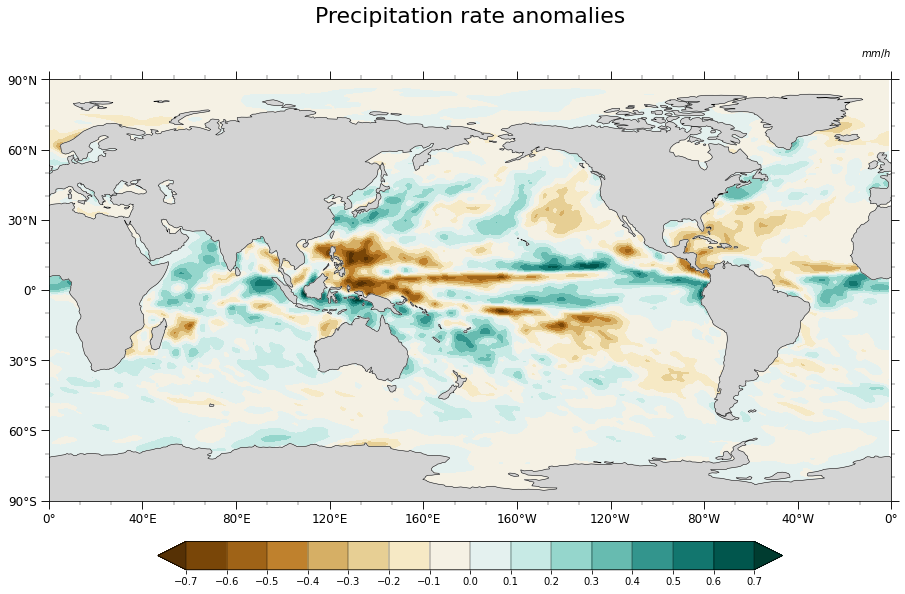

In [37]:
fig = plt.figure(figsize=(16, 10))

#grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[0.85, 0.15],wspace=0.08)
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
contour = prect_anom.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-0.7, 0.8, 0.1),
                           extend='both',
                            cmap = gvcmaps.MPL_BrBG,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)
plt.colorbar(contour,
             ax=ax,
             ticks=np.linspace(-1, 1, 21),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax,maintitle="Precipitation rate anomalies",
                             maintitlefontsize=20,righttitle="$mm/h$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


gvutil.add_major_minor_ticks(ax, labelsize=12)

gvutil.add_lat_lon_ticklabels(ax)
plt.savefig("precip_anomalies.pdf")

## now use regridded TS to surface temeprature anomalies
the time series doesn't show much signal

In [38]:
del dsregrid
del ddregrid

In [39]:
dsregrid = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.cam.h0.TS.033101-040012.nc')
ts0 = dsregrid.TS
ts0

<xarray.DataArray 'TS' (time: 840, lat: 192, lon: 288)>
[46448640 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0331-02-01 00:00:00 ... 0401-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean
    remap:         remapped via ESMF_regrid_with_weights: Bilinear

In [40]:
ddregrid = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.cam.h0.TS.033101-040012.nc')
ts = ddregrid.TS


In [41]:
ts0_clm = ts0.mean('time')
ts_clm = ts[480:840,:,:].mean('time')
ts_clm_anom = ts_clm.copy(data=ts_clm.data-ts0_clm.data)

In [42]:
# now get time series
ts_series = ts[:,0,0].copy(data=ts.mean(('lat','lon')) - ts0_clm.mean(('lat','lon')))


## now use regridded data to get OHC anomaly pattern

In [37]:
dsocn0 = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.ann.TEMP.0301-0330.1x1.nc')
temp01x1 = dsocn0.TEMP

In [38]:
dsocn = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.ann.TEMP.0301-0473.1x1.nc')
temp1x1 = dsocn.TEMP
temp1x1

<xarray.DataArray 'TEMP' (time: 173, z_t: 60, lat: 180, lon: 360)>
[672624000 values with dtype=float32]
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [39]:
temp_diff_1x1 = temp1x1[0,0,:,:].copy(data=temp1x1[70:100,0,:,:].mean('time').data - temp01x1[:,0,:,:].mean('time').data)
temp_diff_1x1

<xarray.DataArray 'TEMP' (lat: 180, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.00081587, 0.00081134, 0.00080657, ..., 0.00083148, 0.0008266 ,
        0.00082159],
       [0.00049317, 0.00049138, 0.000489  , ..., 0.0004977 , 0.00049615,
        0.00049436],
       [0.00019193, 0.00019002, 0.00018859, ..., 0.00019586, 0.00019431,
        0.000193  ]], dtype=float32)
Coordinates:
    time     object 0301-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    z_t      float32 500.0
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [46]:
temp01x1_in_K = change_units(dsocn0,"TEMP","TEMP","degK")
heat01x1= calculate_ohc(temp01x1_in_K, dz_in_m, zt_in_m, 'z_t',1000)
heat01x1

(30, 40, 180, 360)


<xarray.DataArray (time: 30, lat: 180, lon: 360)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14145199e+12, 1.14145437e+12, 1.14145675e+12, ...,
         1.14144487e+12, 1.14144712e+12, 1.14144962e+12],
        [1.14138047e+12, 1.14138197e+12, 1.14138347e+12, ...,
         1.14137622e+12, 1.14137759e+12, 1.14137922e+12],
        [1.14131920e+12, 1.14131970e+12, 1.14132032e+12, ...,
         1.14131745e+12, 1.14131795e+12, 1.14131857e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14146025e+12, 1.14146300e+12, 1.14146562e+12, ...,
         1.14145224e+12, 1.14145487e+12, 1.14145750e+12],
        [1.14137872e+12, 1.14138009e+12, 1.14138159e+12, ...,
         1.14137434e+12, 1.14137572e+12, 1.14137722e+12],
        [1.14131094e+12, 1.14131144e+12, 1.14131207e+12, ...,
         1.14130932e+12, 1.14130982e+12, 1.14131044e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14145424e+12, 1.14145737e+12, 1.14146037e+12, ...,
         1.14144474e+12, 1.14144799e+12, 1.14145099e+12],
        [1.14137309e+12, 1.14137484e+12, 1.14137647e+12, ...,
         1.14136821e+12, 1.14136996e+12, 1.14137147e+12],
        [1.14130857e+12, 1.14130907e+12, 1.14130969e+12, ...,
         1.14130682e+12, 1.14130744e+12, 1.14130807e+12]],

       ...,

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14167545e+12, 1.14168070e+12, 1.14168583e+12, ...,
         1.14165982e+12, 1.14166494e+12, 1.14167019e+12],
        [1.14156503e+12, 1.14156816e+12, 1.14157129e+12, ...,
         1.14155540e+12, 1.14155853e+12, 1.14156191e+12],
        [1.14145662e+12, 1.14145787e+12, 1.14145912e+12, ...,
         1.14145299e+12, 1.14145424e+12, 1.14145549e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14171371e+12, 1.14171984e+12, 1.14172596e+12, ...,
         1.14169558e+12, 1.14170146e+12, 1.14170758e+12],
        [1.14159792e+12, 1.14160142e+12, 1.14160505e+12, ...,
         1.14158704e+12, 1.14159067e+12, 1.14159429e+12],
        [1.14148125e+12, 1.14148250e+12, 1.14148413e+12, ...,
         1.14147713e+12, 1.14147850e+12, 1.14147975e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+0

In [48]:
temp1x1_in_K = change_units(dsocn,"TEMP","TEMP","degK")
heat1x1= calculate_ohc(temp1x1_in_K, dz_in_m, zt_in_m, 'z_t',1000)
heat1x1

(173, 40, 180, 360)


<xarray.DataArray (time: 173, lat: 180, lon: 360)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14146550e+12, 1.14146750e+12, 1.14146937e+12, ...,
         1.14145975e+12, 1.14146162e+12, 1.14146350e+12],
        [1.14138985e+12, 1.14139097e+12, 1.14139197e+12, ...,
         1.14138660e+12, 1.14138772e+12, 1.14138897e+12],
        [1.14132320e+12, 1.14132357e+12, 1.14132395e+12, ...,
         1.14132182e+12, 1.14132220e+12, 1.14132282e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14145549e+12, 1.14145737e+12, 1.14145937e+12, ...,
         1.14144962e+12, 1.14145162e+12, 1.14145362e+12],
        [1.14136734e+12, 1.14136846e+12, 1.14136946e+12, ...,
         1.14136434e+12, 1.14136534e+12, 1.14136646e+12],
        [1.14129519e+12, 1.14129569e+12, 1.14129594e+12, ...,
         1.14129406e+12, 1.14129431e+12, 1.14129494e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14147238e+12, 1.14147463e+12, 1.14147675e+12, ...,
         1.14146587e+12, 1.14146812e+12, 1.14147025e+12],
        [1.14137522e+12, 1.14137622e+12, 1.14137759e+12, ...,
         1.14137159e+12, 1.14137259e+12, 1.14137397e+12],
        [1.14129369e+12, 1.14129419e+12, 1.14129456e+12, ...,
         1.14129231e+12, 1.14129269e+12, 1.14129331e+12]],

       ...,

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14184701e+12, 1.14185126e+12, 1.14185538e+12, ...,
         1.14183413e+12, 1.14183838e+12, 1.14184263e+12],
        [1.14170321e+12, 1.14170546e+12, 1.14170771e+12, ...,
         1.14169595e+12, 1.14169845e+12, 1.14170096e+12],
        [1.14157279e+12, 1.14157366e+12, 1.14157441e+12, ...,
         1.14157016e+12, 1.14157116e+12, 1.14157191e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14185764e+12, 1.14186126e+12, 1.14186501e+12, ...,
         1.14184638e+12, 1.14184988e+12, 1.14185376e+12],
        [1.14172259e+12, 1.14172484e+12, 1.14172684e+12, ...,
         1.14171609e+12, 1.14171834e+12, 1.14172046e+12],
        [1.14159192e+12, 1.14159267e+12, 1.14159329e+12, ...,
         1.14158929e+12, 1.14159017e+12, 1.14159104e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+

In [ ]:
heat_diff_1x1 = heat1x1[0,:,:].copy(data=heat1x1[70:100].mean('time').data - heat01x1.mean('time').data)
heat_diff_1x1

In [ ]:
import cmocean
fig = plt.figure(figsize=(22, 15))
fig.tight_layout(pad=-2)

# ocean heat content in control
ax0 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax0.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour0 = heat01x1.mean('time').plot.contourf(ax=ax0,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.thermal,
                           levels=np.arange(1.1e12, 1.2e12, 5e9),
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour0,
             ax=ax0,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax0,maintitle="Ocean heat content climatology (0-1000 m)",
                             maintitlefontsize=20,righttitle="$W/m^2$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax0, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax0, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax0)


#-------------------------
# SST IN CONTROL

ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour2 = temp01x1[:,0,:,:].mean('time').plot.contourf(ax=ax2,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.thermal,
                           levels=np.arange(0, 30, 1),
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour2,
             ax=ax2,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax2,maintitle="SST climatology",
                             maintitlefontsize=20,righttitle="degC",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax2, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax2, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax2)


#-------------------------



#-------------------------
# ohc diff
ax = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour = heat_diff_1x1.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           levels=np.arange(-2e9, 2.1e9, 2e8),
                           add_colorbar=False,
                           add_labels=False,
                   
                           zorder=0)

plt.colorbar(contour,
             ax=ax,
             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax,maintitle="Ocean heat content anomalies (0-1000 m)",
                             maintitlefontsize=20,righttitle="$W/m^2$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax)

#----
ax1 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cfeature.LAND,facecolor='lightgray', zorder=1)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.5, zorder=1)

contour1 = temp_diff_1x1.plot.contourf(ax=ax1, 
                                     transform=ccrs.PlateCarree(),
                                     extend='both',
                                     levels = np.arange(-.8, 0.9, 0.1),
                                     add_colorbar=False,
                                     add_labels=False,
                                     zorder=0)

plt.colorbar(contour1,
             ax=ax1,
             ticks=np.linspace(-2, 2, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax1,maintitle="SST anomalies",
                             maintitlefontsize=20,righttitle="degC",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax1, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax1, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax1)




plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.02) 


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax2.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax2.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax.text(0.025, 0.9,
            'c)', fontsize=20,
            transform=ax.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'd)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
#plt.show()
plt.savefig("ohc_sst_map.pdf")

Column net radiative balance is reduced in the TC run. this is mainly bacause of increased surface radiative fluxes. More radiative flux into the surface in TC than control. 
<h3 style="color:red"> the surface radiative fluxes are coming from increeased shortwave and decreased longwave </h3>

In [ ]:
temp50_1x1 = temp1x1[0,0,:,:].copy(data=temp1x1[0:5,0,:,:].mean('time').data - temp01x1[:,0,:,:].mean('time').data)
temp50_1x1

In [ ]:
temp50_1x1.plot()

In [ ]:
ax = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour = temp01x1[:,0,:,:].mean('time').plot.contourf(ax=ax2,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.thermal,
                           levels=np.arange(0, 30, 1),
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour2,
             ax=ax2,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax2,maintitle="SST climatology",
                             maintitlefontsize=20,righttitle="degC",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax2, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax2, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax2)


#-------------------------



#-------------------------
# ohc diff
ax = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour = heat_diff_1x1.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           levels=np.arange(-2e9, 2.1e9, 2e8),
                           add_colorbar=False,
                           add_labels=False,
                   
                           zorder=0)

plt.colorbar(contour,
             ax=ax,
             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax,maintitle="Ocean heat content anomalies (0-1000 m)",
                             maintitlefontsize=20,righttitle="$W/m^2$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax)

#----
ax1 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cfeature.LAND,facecolor='lightgray', zorder=1)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.5, zorder=1)

contour1 = temp_diff_1x1.plot.contourf(ax=ax1, 
                                     transform=ccrs.PlateCarree(),
                                     extend='both',
                                     levels = np.arange(-.8, 0.9, 0.1),
                                     add_colorbar=False,
                                     add_labels=False,
                                     zorder=0)

plt.colorbar(contour1,
             ax=ax1,
             ticks=np.linspace(-2, 2, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax1,maintitle="SST anomalies",
                             maintitlefontsize=20,righttitle="degC",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax1, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax1, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax1)




plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.02) 


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax2.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax2.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax.text(0.025, 0.9,
            'c)', fontsize=20,
            transform=ax.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'd)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
#plt.show()
plt.savefig("ohc_sst_map.pdf")

## now plot time sereis of SST, and the el Nino index of the TC simulation. find reasons for the peak at year 100

In [7]:
latS = -5.5
latN = 5.5
lonL = 190.
lonR = 241.
nrun = 3

dst = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.SST.0301-0400.1x1.nc")
TS = dst.TEMP[:,0,:,:]
tropics = TS.sel(lat=slice(latS,latN),lon=slice(lonL,lonR))

time = tropics.time
lat= tropics['lat']
lon = tropics['lon']
ntime = np.size(time)
nlat  = np.size(lat)
nlon = np.size(lon)

In [8]:
ran = np.zeros((12,nlat,nlon)) 
xClm = xr.DataArray(ran,dims = ['month','lat','lon'], coords = [np.arange(1,13),lat,lon])
xClm

i = 0
while i < 12:
    xClm[i,:,:] = tropics[i:ntime:12,:,:].mean('time')
    i = i + 1

# expand then stack to create repeating climatology
    
xClm_4d = xClm.expand_dims({'year':np.arange(1,101)},0)
stacked = xClm_4d.stack(t=('year','month'))
xClm_3d = stacked.transpose('t','lat','lon')
xAnom = tropics
xAnom = tropics-xClm_3d.data

xAnom_avg = xAnom.mean(('lat','lon')).rolling(time=nrun, center=True).mean()
xAnom_min = np.random.rand(ntime)
xAnom_min[:] = -0.5
xAnom_max = np.random.rand(ntime)
xAnom_max[:] = 0.5

Text(0.5, 0, 'year')

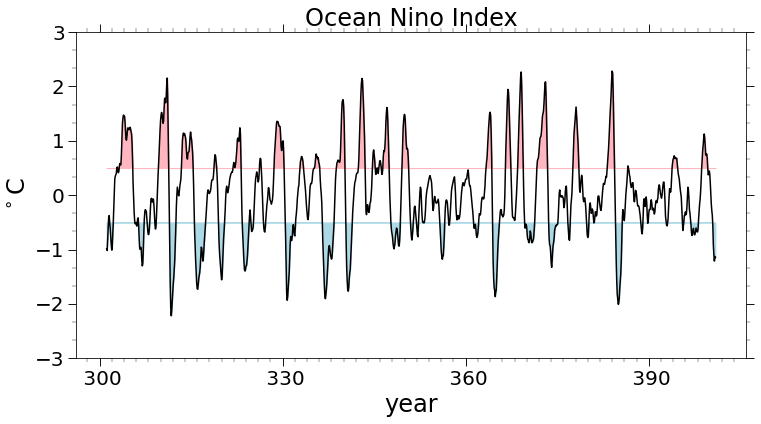

In [9]:
fig,ax = plt.subplots(figsize=(12,6))
x = xAnom_avg.time.dt.year

ax.plot(xAnom_avg.time,xAnom_avg,color='black',label='ONI')
gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)

gvutil.set_axes_limits_and_ticks(ax,ylim=(-3., 3.))
ax.fill_between(xAnom_avg.time.values, xAnom_min, np.min([xAnom_avg.data,xAnom_min],axis=0), color='lightblue', zorder=0)
ax.fill_between(xAnom_avg.time.values, xAnom_max, np.max([xAnom_avg.data,xAnom_max],axis=0), color='lightpink', zorder=1)

ax.set_title('Ocean Nino Index', fontsize=24)#, pad=60.0)
ax.set_ylabel('$^\circ$C', fontsize=24)
ax.set_xlabel('year',fontsize=24)

In [10]:
dst_tc = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.SST.0301-0473.1x1.nc")
TS2 = dst_tc.TEMP[:,0,:,:]
tropics2 = TS2.sel(lat=slice(latS,latN),lon=slice(lonL,lonR))
time2 = tropics2.time
ntime2 = np.size(time2)
TS2

<xarray.DataArray 'TEMP' (time: 2088, lat: 180, lon: 360)>
[135302400 values with dtype=float32]
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0474-01-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    z_t      float32 500.0
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [11]:
xClm_4d2 = xClm.expand_dims({'year':np.arange(1,175)},0)
stacked2 = xClm_4d2.stack(t=('year','month'))
xClm_3d2 = stacked2.transpose('t','lat','lon')
xAnom2 = tropics2
xAnom2 = tropics2-xClm_3d2.data

xAnom_avg2 = xAnom2.mean(('lat','lon')).rolling(time=nrun, center=True).mean()
xAnom_min2 = np.random.rand(ntime2)
xAnom_min2[:] = -0.5
xAnom_max2 = np.random.rand(ntime2)
xAnom_max2[:] = 0.5

Text(0.5, 0, 'year')

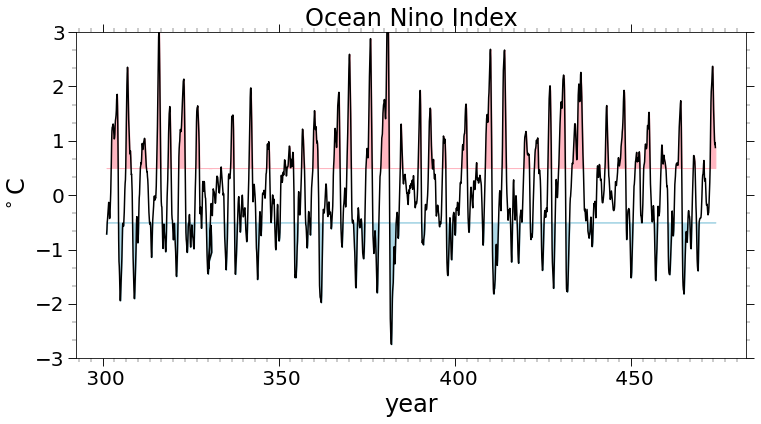

In [10]:
fig,ax = plt.subplots(figsize=(12,6))
x = xAnom_avg2.time.dt.year

ax.plot(xAnom_avg2.time[0:2880],xAnom_avg2[0:2880],color='black',label='ONI')
gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)

gvutil.set_axes_limits_and_ticks(ax,ylim=(-3., 3.))
ax.fill_between(xAnom_avg2[0:2880].time.values, xAnom_min2[0:2880], np.min([xAnom_avg2[0:2880].data,xAnom_min2[0:2880]],axis=0), color='lightblue', zorder=0)
ax.fill_between(xAnom_avg2[0:2880].time.values, xAnom_max2[0:2880], np.max([xAnom_avg2[0:2880].data,xAnom_max2[0:2880]],axis=0), color='lightpink', zorder=1)

ax.set_title('Ocean Nino Index', fontsize=24)#, pad=60.0)
ax.set_ylabel('$^\circ$C', fontsize=24)
ax.set_xlabel('year',fontsize=24)

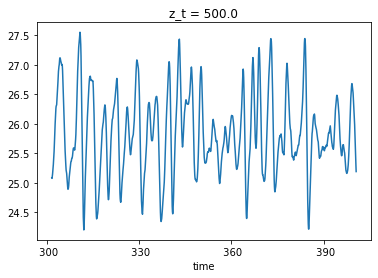

In [11]:
tropics.mean(('lat','lon')).rolling(time=12, center=True).mean().plot()

In [12]:
anom =  TS.copy(data=TS2[0:1200].data - TS.data)


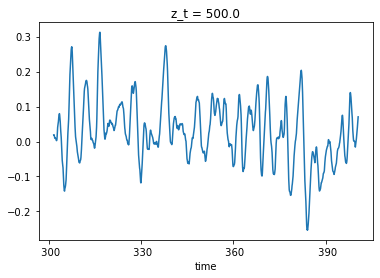

In [13]:

anom.mean(('lat','lon')).rolling(time=12, center=True).mean().plot()

In [60]:
TLAT = ds.TLAT
temp_diff = tempetc.copy(data=(tempetc.data-temp0.mean('time').data))
temp_diff

KeyboardInterrupt: 

In [ ]:
trop1 = temp_diff.where(TLAT<40)
trop2 = trop1.where(TLAT>-40)
plt_temp = trop2.transpose('z_t','time','nlat','nlon')
plt_temp

In [ ]:
fig3,ax= plt.subplots(figsize=(13, 8))   # now you can reference the first object
cs2 = ax.contourf(np.arange(0,120,1),zt_in_m.isel(z_t=slice(0,42)), plt_temp.isel(z_t=slice(0,42), time=slice(0,120)).mean(('nlat','nlon')),levels=np.arange(-1.,1.1,0.1),cmap=gvcmaps.BlueWhiteOrangeRed)
ax.invert_yaxis()
ax.set_title('40S-40N average temeprature, time-depth', fontsize=23)
ax.set_ylabel('depth (m)')

ax.set_xlabel('year')
fig3.colorbar(cs2, ax=ax)

# Get  tropical ocean temperature anomalies structure

In [ ]:
#dsocn0 = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.ann.TEMP.0301-0330.1x1.nc')
#temp01x1 = dsocn0.TEMP
#temp01x1

In [ ]:
#dsocn = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.ann.TEMP.0301-0473.1x1.nc')

In [ ]:
#temp1x1 = dsocn.TEMP


In [40]:
trop_diff = temp1x1[:,:,80:100,:].copy(data=(temp1x1[:,:,80:100,:] - temp01x1[:,:,80:100,:].mean('time')))

## latitudinal cross section in the north Pacific

In [41]:
plt_trop_diff = trop_diff[70:100,0:40,:,120:280].mean(('time','lat')).transpose('z_t','lon')
plt_trop0 =temp01x1[:,:,80:100,:].mean(('time','lat')).transpose('z_t','lon')
nwp_diff = temp1x1[:,:,30:150,180:250].mean('lon').copy(data=(temp1x1[:,:,30:150,180:250].mean('lon') - temp01x1[:,:,30:150,180:250].mean(('time','lon'))))

In [42]:
np.arange(8,32,4)

array([ 8, 12, 16, 20, 24, 28])

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


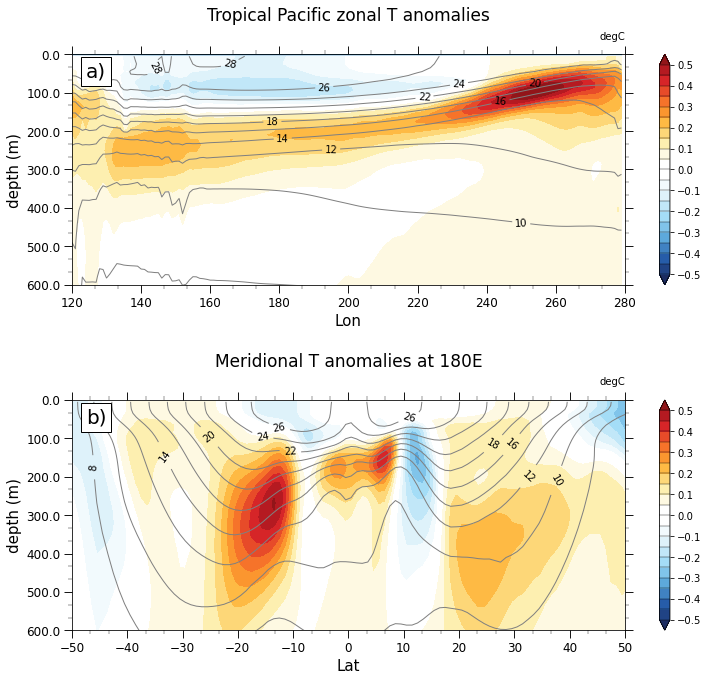

In [49]:
plt_nwp_diff = nwp_diff[70:100,0:40].mean('time').transpose('z_t','lat')
plt_nwp0 = temp01x1[:,:,30:150,180:250].mean(('time','lon'))


fig5,[ax0, ax1] = plt.subplots(2, 1,figsize=(12, 10))   # now you can reference the first object

plt_diff = plt_trop_diff.isel(z_t=slice(0,40)).plot.contourf(ax=ax0,
                                                             levels=np.arange(-0.5, 0.55, 0.05),
                                                             extend='both',
                                                             cmap=gvcmaps.BlueWhiteOrangeRed,
                                                             add_colorbar=False,
                                                             add_labels=False)

#cs0 = ax0.contourf(plt_trop_diff.lon,zt_in_m.isel(z_t=slice(0,40)), plt_trop_diff, levels=np.arange(-.5,0.55,0.05),  extend='both',cmap = gvcmaps.BlueWhiteOrangeRed)

plt0 = plt_trop0.isel(z_t=slice(0,40),lon=slice(120,280)).plot.contour(ax=ax0,
                       levels=np.arange(8,32,2),
                       colors='gray',
                       linewidths=1.0,
                       add_labels=False)
ax0.clabel(plt0, np.arange(8,32,2), fmt='%d', inline=True, colors='black')

# overlay mixed layer depth on top?
cs0 = ax0.plot(np.arange(120,280),hmxl0_in_m[:,80:100,120:280].mean(('time','lat')))



plt.colorbar(plt_diff,
             ax=ax0,
             ticks=np.linspace(-.5, .5, 11),
             orientation='vertical',            
             drawedges=True,
             )

ax0.invert_yaxis()

ax0.set_ylabel('depth (m)',fontsize=15)
ax0.set_xlabel('Lon', fontsize=15)
gvutil.add_major_minor_ticks(ax0, labelsize=12)
gvutil.set_titles_and_labels(ax0,maintitle='Tropical Pacific zonal T anomalies',
                             maintitlefontsize=15,righttitle="degC",righttitlefontsize=10)

gvutil.set_axes_limits_and_ticks(ax0, xlim=(120, 280),
                                 ylim=(60000, 0),
                                 xticks=np.linspace(120, 280, 9))
                               # yticks=np.linspace(400, 0, 100))


ax0.set_yticklabels(np.linspace(0,600,7))
#plt.show()



#-------------------------
#cs1 = ax1.contourf(plt_nwp_diff.lat,zt_in_m.isel(z_t=slice(0,40)), plt_nwp_diff, levels=np.arange(-.5,.55,0.05), extend='both',cmap=gvcmaps.BlueWhiteOrangeRed)
plt_diff1=plt_nwp_diff.isel(z_t=slice(0,40)).plot.contourf(ax=ax1, levels=np.arange(-0.5,0.55, 0.05),extend='both',cmap=gvcmaps.BlueWhiteOrangeRed,
                                   add_colorbar=False,
                                   add_labels=False)


plt1 = plt_nwp0.isel(z_t=slice(0,40)).plot.contour(ax=ax1,
                       levels=np.arange(8,32,2),
                       colors='gray',
                       linewidths=1.0,
                       add_labels=False)
                     
ax1.clabel(plt1, np.arange(8,32,2), fmt='%d', inline=True, colors='black')


plt.colorbar(plt_diff1,
             ax=ax1,
             ticks=np.linspace(-.5, .5, 11),
             orientation='vertical',            
             drawedges=True,
             )

ax1.invert_yaxis()



ax1.set_ylabel('depth (m)',fontsize=15)
ax1.set_xlabel('Lat',fontsize=15)

gvutil.set_titles_and_labels(ax1,maintitle='Meridional T anomalies at 180E',
                             maintitlefontsize=15,righttitle="degC",righttitlefontsize=10)

gvutil.set_axes_limits_and_ticks(ax1, xlim=(-50, 50),
                                 ylim=(60000, 0),
                                 xticks=np.linspace(-50, 50, 11))


ax1.set_yticklabels(np.linspace(0,600,7))


plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.5) 


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
gvutil.add_major_minor_ticks(ax1, labelsize=12)

plt.savefig("ocn_temp_anom_sections.pdf")
plt.show()

#moc0[:,0,0,:,:].mean('time').plot()


In [96]:
plt0
cs0

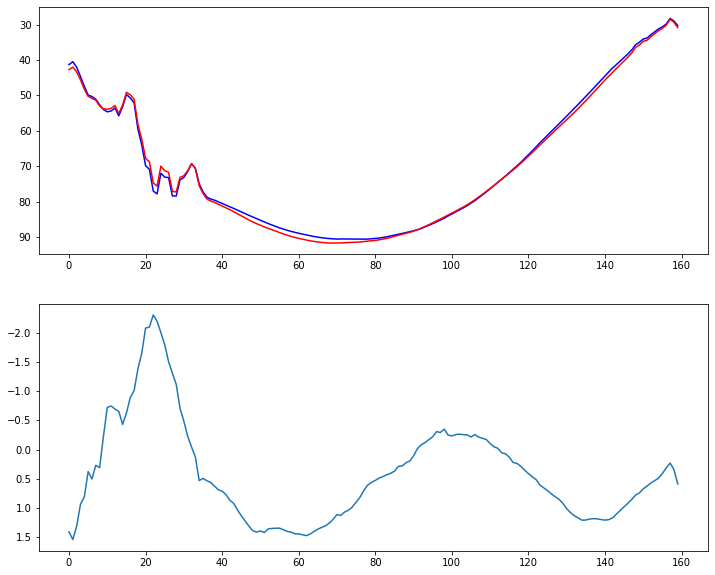

In [58]:
#hmxl0_in_m[:,:,180:250].mean(('time','lon')).plot()
fig5,ax0 = plt.subplots(2, 1,figsize=(12, 10))   # now you can reference the first object

#plt00 = hmxl0_in_m[:,80:100,120:280].mean(('time','lat')).plot(ax=ax0)
cs0 = ax0[0].plot(hmxl0_in_m[:,80:100,120:280].mean(('time','lat')),color='blue')
cs01 =ax0[0].plot(hmxl_in_m[:,80:100,120:280].mean(('time','lat')),color='red')
cs1 = ax0[1].plot(hmxl_diff[:,80:100,120:280].mean(('time','lat')))      
ax0[0].invert_yaxis()
ax0[1].invert_yaxis()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


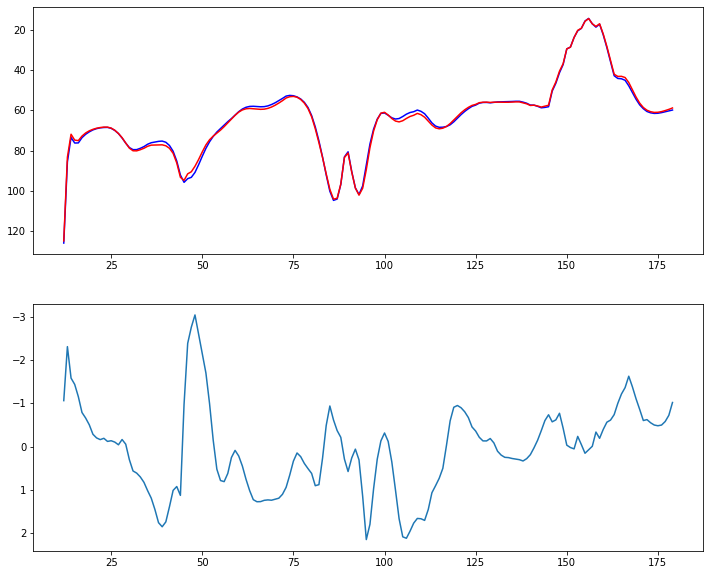

In [59]:
#hmxl0_in_m[:,:,180:250].mean(('time','lon')).plot()
fig5,ax0 = plt.subplots(2, 1,figsize=(12, 10))   # now you can reference the first object

cs0 = ax0[0].plot(hmxl0_in_m[:,:,180:240].mean(('time','lon')),color='blue')
cs01 =ax0[0].plot(hmxl_in_m[:,:,180:240].mean(('time','lon')),color='red')
cs1 = ax0[1].plot(hmxl_diff[:,:,180:240].mean(('time','lon')))      
ax0[0].invert_yaxis()
ax0[1].invert_yaxis()

# Now ocean mixed layer depth diagnose

## annual climatology

In [44]:
dsh = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.ann.hmxl.0330-0473.1x1.nc")
hmxl = dsh.HMXL
bsf = dsh.BSF

In [45]:
dsh0 = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact.pop.h.ann.hmxl.0301-0320.1x1.nc")
hmxl0= dsh0.HMXL
bsf0 = dsh0.BSF

In [46]:
hmxl0_in_m = change_units(dsh0, "HMXL", "HMXL", "m")
hmxl_in_m = change_units(dsh, "HMXL", "HMXL", "m")

In [47]:
bsf_diff = bsf.copy(data=(bsf.data-bsf0.mean('time').data))
bsf_diff_mask= bsf_diff.where(bsf_diff.data!=0)

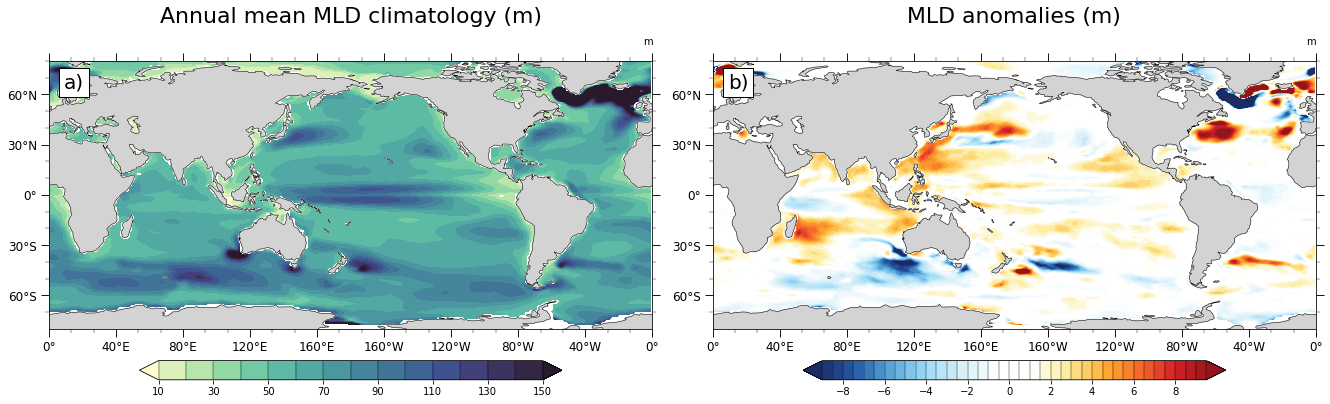

In [48]:
hmxl_diff = hmxl_in_m.copy(data=(hmxl_in_m.data-hmxl0_in_m.mean('time').data))
hmxl_diff_mask= hmxl_diff.where(hmxl_diff.data!=0)

fig = plt.figure(figsize=(22, 15))
fig.tight_layout(pad=-2)

# ocean heat content in control
ax0 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax0.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

levels = np.arange(10,160,10)
contour0 = hmxl0_in_m.mean('time').plot.contourf(ax=ax0,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.deep,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour0,
             ax=ax0,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax0,maintitle="Annual mean MLD climatology (m)",
                             maintitlefontsize=20,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax0, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax0, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax0)

#---------
# plot diff

ax1 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
levels2 = np.arange(-9.,10.,0.5)
contour1 = hmxl_diff_mask[40:70,:,:].mean('time').plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = gvcmaps.BlueWhiteOrangeRed,
                           levels=levels2,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)





plt.colorbar(contour1,
             ax=ax1,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)

gvutil.set_titles_and_labels(ax1,maintitle="MLD anomalies (m)",
                             maintitlefontsize=20,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax1, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


gvutil.add_major_minor_ticks(ax1, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax1)




plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.05) 


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

plt.savefig("annual_mld_anom_2panel.pdf")




## plot bsf and surface wind stress anomalies

## now seasonal hmxl and sst seasonality

In [5]:
dsh0m = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact.pop.h.monclm.0301-0320.1x1.nc')
hmxl_m0 = change_units(dsh0m, 'HMXL','HMXL','m')
temp_m0 = change_units(dsh0m,'TEMP','TEMP','degC')


In [6]:
dshm = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.monclm.0370-0399.1x1.nc')
hmxl_m = change_units(dshm, 'HMXL','HMXL','m')
temp_m = change_units(dshm,'TEMP','TEMP','degC')


In [7]:
hmxl_m_diff = hmxl_m.copy(data=(hmxl_m.data-hmxl_m0.data))
hmxl_m_diff

<xarray.DataArray (time: 12, lat: 180, lon: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.9145355 , -1.9283905 , -1.942215  , ..., -1.8733826 ,
         -1.8869781 , -1.9006348 ],
        [-1.4922867 , -1.4927292 , -1.4929276 , ..., -1.4895477 ,
         -1.4907074 , -1.4916153 ],
        [-1.0852966 , -1.0858383 , -1.0863647 , ..., -1.0835495 ,
         -1.0841599 , -1.0847397 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.346199  , -1.3731232 , -1.4001617 , ..., -1.2655411 ,
         -1.2924576 , -1.3193817 ],
        [-0.7253189 , -0.72151184, -0.7171631 , ..., -0.73337555,
         -0.7312546 , -0.72856903],
        [-0.11791229, -0.11456299, -0.11116028, ..., -0.12756348,
         -0.12440491, -0.12119293]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.55165863, -0.5717468 , -0.59150696, ..., -0.49228668,
         -0.51174164, -0.53125   ],
        [-0.09427643, -0.10783386, -0.12143707, ..., -0.05381775,
         -0.06726074, -0.08075714],
        [ 0.32502747,  0.32112122,  0.3172989 , ...,  0.33735657,
          0.3331375 ,  0.32904053]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.0838089 , -1.1063957 , -1.1290512 , ..., -1.0188942 ,
         -1.0399857 , -1.0612946 ],
        [-1.0006142 , -1.0136223 , -1.0266266 , ..., -0.96162415,
         -0.974617  , -0.9876175 ],
        [-0.94714737, -0.95183945, -0.95650864, ..., -0.9328842 ,
         -0.93767166, -0.9424286 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.2635765 , -1.2802048 , -1.296711  , ..., -1.2132034 ,
         -1.2301025 , -1.2468262 ],
        [-0.8261337 , -0.83514404, -0.8439903 , ..., -0.7980728 ,
         -0.8075943 , -0.81694794],
        [-0.45233917, -0.4544983 , -0.45661163, ..., -0.44555283,
         -0.44786453, -0.45013046]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.7938766 , -1.8122177 , -1.8303604 , ..., -1.7375488 ,
         -1.7565155 , -1.7753143 ],
        [-1.3152695 , -1.327919  , -1.3405304 , ..., -1.2771301 ,
         -1.2898712 , -1.3025742 ],
        [-0.7748413 , -0.7794647 , -0.7840347 , ..., -0.7606354 ,
         -0.765419  , -0.77015686]]], dtype=float32)
Coordinates:
  * time     (time) object 0370-02-01 00:00:00 ... 0371-01-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 3

In [8]:
temp_m_diff = temp_m.copy(data=temp_m.data - temp_m0.data)
temp_m_diff

<xarray.DataArray (time: 12, z_t: 60, lat: 180, lon: 360)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [-7.80820847e-05, -8.78572464e-05, -9.70363617e-05, ...,
          -5.66244125e-05, -6.15119934e-05, -6.78300858e-05],
         [-5.98430634e-05, -6.22272491e-05, -6.46114349e-05, ...,
          -5.22136688e-05, -5.48362732e-05, -5.73396683e-05],
         [ 1.70469284e-05,  2.01463699e-05,  2.33650208e-05, ...,
           7.51018524e-06,  1.07288361e-05,  1.38282776e-05]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [-6.44922256e-05, -7.36713409e-05, -8.22544098e-05, ...,
          -4.35113907e-05, -4.83989716e-05, -5.45978546e-05],
         [-5.74588776e-05, -6.03199005e-05, -6.29425049e-05, ...,
          -4.87565994e-05, -5.17368317e-05, -5.45978546e-05],
         [ 2.27689743e-05,  2.56299973e-05,  2.84910202e-05, ...,
           1.41859055e-05,  1.70469284e-05,  1.97887421e-05]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [-5.99622726e-05, -6.96182251e-05, -7.86781311e-05, ...,
          -3.86238098e-05, -4.35113907e-05, -4.98294830e-05],
         [-5.55515289e-05, -5.82933426e-05, -6.10351562e-05, ...,
          -4.64916229e-05, -4.95910645e-05, -5.26905060e-05],
         [ 1.93119049e-05,  2.25305557e-05,  2.57492065e-05, ...,
           9.53674316e-06,  1.27553940e-05,  1.59740448e-05]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

       

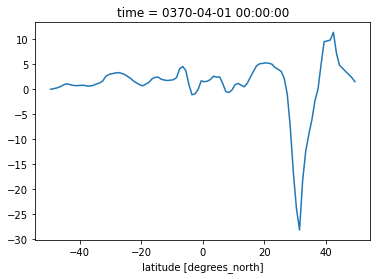

In [30]:
hmxl_m_diff[2,40:140,120:180].mean('lon').plot()

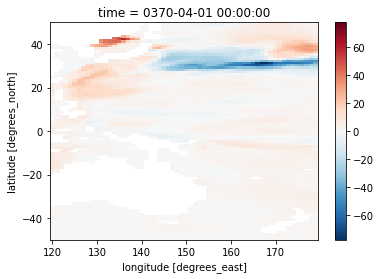

In [29]:
hmxl_m_diff[2,40:140,120:180].plot()

# animation of tropical sst

 read in monthly climatology file

In [ ]:
temp_trop = temp_m_diff.isel(z_t=slice(0,40),lon=slice(120,280), lat=slice(80,100)).mean('lat')
temp_trop0 = temp_m0.isel(z_t=slice(0,40),lon=slice(120,280), lat=slice(80,100)).mean('lat')

temp_nwp = temp_m_diff.isel(z_t=slice(0,40),lon=180, lat=slice(80,150))
temp_nwp0 = temp_m0.isel(z_t=slice(0,40),lon=180, lat=slice(80,150))

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(20,10))

temp_trop.isel(time=0,z_t=slice(0,40),lon=slice(120,280)).plot.contourf(ax=ax,
                            levels=np.arange(-1.,1.1, 0.1),
                            extend='both',
                           colors=cmocean.cm.balance,
                           cbar_kwargs={
                               "drawedges":True,
                               "extendrect": True,
                               "orientation": "horizontal",
                               "ticks": np.arange(-1.,1.1, 0.1),
                               "label": "",
                               "shrink": 0.80
                           })



# animate function for matplotlib FuncAnimation
def animate(i):
    temp_trop.isel(time=i,z_t=slice(0,40),lon=slice(120,280)).plot.contourf(ax=ax,
                       levels=np.arange(-1, 1.1, 0.1),
                        extend='both',
                       colors=cmocean.cm.balance,
                       add_colorbar=False)



    ax.invert_yaxis()
    
    gvutil.set_titles_and_labels(
        ax,
        xlabel="",
        ylabel="")


# runs the animation initiated with the frame from init and progressed with the animate function
anim = animation.FuncAnimation(fig, animate, frames=12, interval=200)

anim.save('animate_1.gif', writer='pillow', fps=5)



In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(20,10))

levels2= np.arange(-1, 1.1, 0.1)
# animate function for matplotlib FuncAnimation
def animate(i):
    temp_nwp.isel(time=i,z_t=slice(0,40)).plot.contourf(ax=ax,
                       levels=levels2,
                        extend='both',
                       colors=cmocean.cm.balance,
                       add_colorbar=False)
    
    ax.invert_yaxis()

    
    gvutil.set_titles_and_labels(
        ax,
        xlabel="",
        ylabel="")


# runs the animation initiated with the frame from init and progressed with the animate function
anim = animation.FuncAnimation(fig, animate, frames=12, interval=200)

anim.save('animate_2.gif', writer='pillow', fps=5)



In [ ]:

hmxl_nh_summer0 = hmxl_m0[7:10].mean('time')
hmxl_nh_winter0 = (hmxl_m0[11] + hmxl_m0[0:3].mean('time') *4 ) / 5.
hmxl_nh_summer = hmxl_m_diff[7:10].mean('time')
hmxl_nh_winter = (hmxl_m_diff[11] + hmxl_m_diff[0:3].mean('time') *4 ) / 5.

In [ ]:
temp_m_diff= temp_m.copy(data = (temp_m.data - temp_m0.data))

In [ ]:
sst_nh_summer0 =temp_m0.isel(z_t=0,time=slice(6,10)).mean('time')
sst_nh_winter0 = (temp_m0.isel(z_t=0,time=11) + temp_m0.isel(z_t=0,time=slice(0,3)).mean('time') *4 ) / 5.

sst_nh_summer =temp_m_diff.isel(z_t=0,time=slice(6,10)).mean('time')
sst_nh_winter = (temp_m_diff.isel(z_t=0,time=11) + temp_m_diff.isel(z_t=0,time=slice(0,4)).mean('time') *5 ) / 6.

In [ ]:
fig = plt.figure(figsize=(22, 22))
fig.tight_layout(pad=-2)

ax0 = plt.subplot(3, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax0.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

levels = np.arange(0,160,10)
contour0 = hmxl_nh_summer0.plot.contourf(ax=ax0,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.deep,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour0,
             ax=ax0,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax0,maintitle="NH summer (Aug-Nov) MLD climatology (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax0, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax0, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax0)


#------------


ax1 = plt.subplot(3, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)


contour1 = hmxl_nh_winter0.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.deep,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour1,
             ax=ax1,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax1,maintitle="NH winter (Dec-Apr) MLD climatology (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax1, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))



gvutil.add_major_minor_ticks(ax1, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax1)


#--------------


ax2 = plt.subplot(3, 2, 3, projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

levels = np.arange(-13.,14.,1)
contour2 = hmxl_nh_summer.plot.contourf(ax=ax2,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.balance,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour2,
             ax=ax2,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax2,maintitle="NH summer (Jul-Nov) MLD anoamalies (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax2, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax2, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax2)

#---- winter 

ax3 = plt.subplot(3, 2, 4, projection=ccrs.PlateCarree(central_longitude=180))
ax3.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour3 = hmxl_nh_winter.plot.contourf(ax=ax3,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.balance,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour3,
             ax=ax3,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax3,maintitle="NH winter (Dec-Apr) MLD anomalies (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax3, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax3, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax3)


plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.03) 



###############################
# now sst

ax4= plt.subplot(3, 2, 5, projection=ccrs.PlateCarree(central_longitude=180))
ax4.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax4.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

levels = np.arange(-1.,1.1,0.1)
contour4 = sst_nh_summer.plot.contourf(ax=ax4,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.balance,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour4,
             ax=ax4,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax4,maintitle="NH summer (Jul-Nov) SST anoamalies (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax4, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax4, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax4)

#---- winter 

ax5 = plt.subplot(3, 2, 6, projection=ccrs.PlateCarree(central_longitude=180))
ax5.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax5.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour5 = sst_nh_winter.plot.contourf(ax=ax5,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.balance,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour5,
             ax=ax5,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax5,maintitle="NH winter (Dec-Apr) SST anomalies (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax5, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax5, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax5)


plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.05) 


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax2.text(0.025, 0.9,
            'c)', fontsize=20,
            transform=ax2.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
ax3.text(0.025, 0.9,
            'd)', fontsize=20,
            transform=ax3.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax4.text(0.025, 0.9,
            'e)', fontsize=20,
            transform=ax4.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax5.text(0.025, 0.9,
            'f)', fontsize=20,
            transform=ax5.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
plt.savefig("sst_season_anom_4panel.pdf")

# now AMOC timeseires

In [5]:
ds_moc = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.ann.moc.0301-0330.nc")
moc0 = ds_moc.MOC
heat0 = ds_moc.N_HEAT
heat0

<xarray.DataArray 'N_HEAT' (time: 30, transport_reg: 2, transport_comp: 5, lat_aux_grid: 395)>
[118500 values with dtype=float32]
Coordinates:
    transport_components  (transport_comp) |S256 ...
    transport_regions     (transport_reg) |S256 ...
  * time                  (time) object 0301-02-01 00:00:00 ... 0330-02-01 00:00:00
  * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
Dimensions without coordinates: transport_reg, transport_comp
Attributes:
    long_name:     Northward Heat Transport
    units:         Pwatt
    cell_methods:  time: mean

In [6]:
mocz_in_m = change_units(ds_moc, "moc_z", "moc_z", "m")

In [7]:
ds_moc_e = xr.open_dataset("./data/b.e13.B1850C5CN.ne30_g16.005ax_exact.pop.h.ann.moc.0301-0320.nc")
moce = ds_moc_e.MOC
heate = ds_moc_e.N_HEAT

In [8]:
ds_moc_tc = xr.open_dataset('./data/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.ann.moc.0330-0473.nc')
moctc = ds_moc_tc.MOC
heattc = ds_moc_tc.N_HEAT
heattc

<xarray.DataArray 'N_HEAT' (time: 144, transport_reg: 2, transport_comp: 5, lat_aux_grid: 395)>
[568800 values with dtype=float32]
Coordinates:
    transport_components  (transport_comp) |S256 ...
    transport_regions     (transport_reg) |S256 ...
  * time                  (time) object 0330-02-01 00:00:00 ... 0473-02-01 00:00:00
  * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
Dimensions without coordinates: transport_reg, transport_comp
Attributes:
    long_name:     Northward Heat Transport
    units:         Pwatt
    cell_methods:  time: mean

In [9]:
ds_moc_tc1 = xr.open_dataset('./data/b.e13.B1850C5CN.ne30_g16.005ax_exact_tc.pop.h.ann.moc.0301-0330.nc')
moctc1 = ds_moc_tc1.MOC


In [10]:
moc_new=xr.concat([moctc1,moctc],dim="time")
moc_new.isel(moc_comp=0)

<xarray.DataArray 'MOC' (time: 174, transport_reg: 2, moc_z: 61, lat_aux_grid: 395)>
array([[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           2.6008545e-05,  6.6926564e-06, -1.0367975e-06],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           1.6295278e-03,  4.7084593e-04,  1.4793012e-05],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           3.3532390e-03,  9.8003715e-04,  2.9805988e-05],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -8.8764540e-07, -8.8764540e-07, -8.8764540e-07],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -5.6731250e-07, -5.6731250e-07, -5.6731250e-07],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 8.9128572e-01,  8.9128572e-01,  8.9128572e-01, ...,
           8.3446753e-01,  8.3444822e-01,  8.3444053e-01],
         [ 1.8201240e+00,  1.8201240e+00,  1.8201240e+00, ...,
           5.8209950e-01,  5.8094084e-01,  5.8048481e-01],
         [ 2.6705871e+00,  2.6705871e+00,  2.6705871e+00, ...,
           3.0199635e-01,  2.9962301e-01,  2.9867277e-01],
         ...,
         [ 3.3465873e-02,  3.3465873e-02,  3.3465873e-02, ...,
          -1.8308590e-07, -1.8308590e-07, -1.8308590e-07],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -1.4175875e-07, -1.4175875e-07, -1.4175875e-07],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]],


       [[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -1.1196632e-05, -4.6304185e-06, -1.9538516e-06],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           2.9114990e-03,  9.0584252e-04,  5.8139021e-06],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           4.9705873e-03,  1.5443803e-03,  2.5594556e-05],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           2.3934274e-06,  2.3934274e-06,  2.3934274e-06],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           9.4465702e-07,  9.4465702e-07,  9.4465702e-07],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 8.3505934e-01,  8.3505934e-01,  8.3505934e-01, ...,
           8.5159248e-01,  8.5159904e-01,  8.5160172e-01],
         [ 1.7949106e+00,  1.7949106e+00,  1.7949106e+00, ...,
           5.9369284e-01,  5.9168726e-01,  5.9078723e-01],
         [ 2.6738002e+00,  2.6738002e+00,  2.6738002e+00, ...,
           3.0899927e-01,  3.0557320e-01,  3.0405441e-01],
         ...,
         [-4.1036215e-02, -4.1036215e-02, -4.1036215e-02, ...,
           6.4113942e-07,  6.4113942e-07,  6.4113942e-07],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -1.8379043e-07, -1.8379043e-07, -1.8379043e-07],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]],


       [[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -5.5100092e-05, -1.6716112e-05, -1.5814578e-06],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -9.3091885e-04, -1.2849289e-04,  2.4706836e-05],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -1.2124634e-03, -2.7965920e-04, -7.8753787e-05],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           1.9258700e-06,  1.9258700e-06,  1.9258700e-06],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           4.0152057e-07,  4.0152057e-07,  4.0152057e-07],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 7.5529325e-01,  7.5529325e-01,  7.5529325e-01, ...,
           7.7047569e-01,  7.7051407e-01,  7.7052915e-01],
         [ 1.9096853e+00,  1.9096853e+00,  1.9096

Find MOC value

In [11]:
moc0_series = moc0[:,:,0,33:59,50:395].max(dim=("moc_z","lat_aux_grid"))
moc0_series[:,0].mean('time')

<xarray.DataArray 'MOC' ()>
array(36.480698, dtype=float32)
Coordinates:
    transport_regions  |S256 b'Global Ocean - Marginal Seas'

In [16]:
moce_series = moce[:,:,0,33:59,50:395].max(dim=("moc_z","lat_aux_grid"))
moce_series[:,1].mean('time')

<xarray.DataArray 'MOC' ()>
array(23.278513, dtype=float32)
Coordinates:
    transport_regions  |S256 ...

In [17]:
moctc_series = moc_new[:,:,0,33:59,50:395].max(dim=("moc_z","lat_aux_grid"))

In [18]:
moc_anom = moctc_series.copy(data=(moctc_series-moce_series.mean('time')))

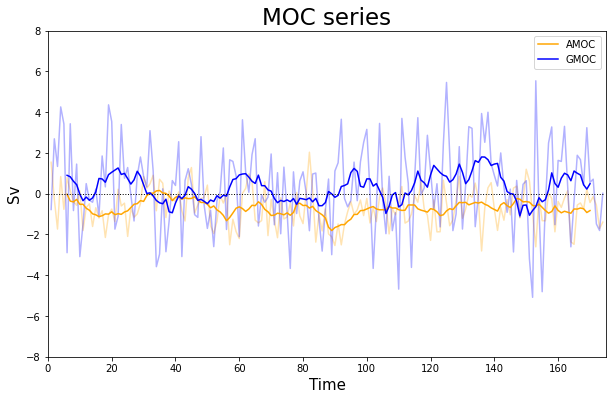

In [31]:
fig, ax0 = plt.subplots(figsize=(10,6))

ax0.plot(np.arange(1,175,step=1), moc_anom[:,1],color="orange",alpha=0.3 )
ax0.plot(np.arange(1,175,step=1), moc_anom[:,0],color="blue", alpha=.3 )

ax0.plot(np.arange(1,175,step=1), moc_anom[:,1].rolling(time=10,center=True).mean(),color="orange", label="AMOC" )
ax0.plot(np.arange(1,175,step=1), moc_anom[:,0].rolling(time=10,center=True).mean(),color="blue", label="GMOC" )

ax0.plot(np.arange(0,175,step=1), np.zeros(175),color="black", lw=1,linestyle=':', )
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels)

gvutil.set_axes_limits_and_ticks(ax0,ylim=(-8., 8.),xlim=(0,175))
ax0.set_title("MOC series",fontsize=23)


ax0.set_ylabel('Sv',fontsize=15)
ax0.set_xlabel('Time', fontsize=15)
plt.savefig("moc_series.pdf")

In [15]:
moc_diff = moc_new.copy(data=moc_new.data - moc0.mean('time').data)
depth=26
plt_moc = moce[:,0,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')
plt_moc_tc = moc_new[:,0,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')
plt_moc_diff = moc_diff[70:100,0,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')

plt_amoc = moce[:,1,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')
plt_amoc_tc = moc_new[:,1,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')
plt_amoc_diff = moc_diff[70:100,1,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')


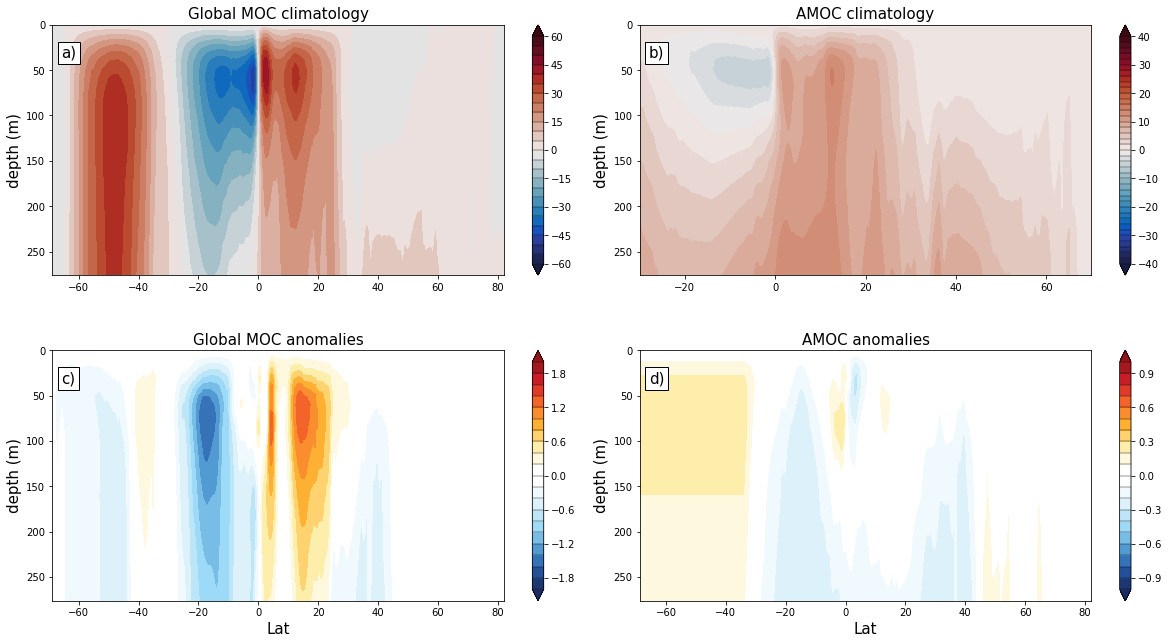

In [17]:
import cmocean
fig5, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2,figsize=(20, 10))   # now you can reference the first object
cs0 = ax0.contourf(plt_moc.lat_aux_grid,mocz_in_m.isel(moc_z=slice(0,depth)), plt_moc, levels=np.arange(-60,65,5),cmap=cmocean.cm.balance, extend='both')
cs1 = ax1.contourf(plt_amoc.lat_aux_grid,mocz_in_m.isel(moc_z=slice(0,depth)), plt_amoc, levels=np.arange(-40,42,2),cmap=cmocean.cm.balance, extend='both')

cs2 = ax2.contourf(plt_moc_diff.lat_aux_grid,mocz_in_m.isel(moc_z=slice(0,depth)), plt_moc_diff,levels=np.arange(-2,2.2,0.2),cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
cs3 = ax3.contourf(plt_amoc_diff.lat_aux_grid,mocz_in_m.isel(moc_z=slice(0,depth)), plt_amoc_diff,levels=np.arange(-1,1.1,0.1),cmap=gvcmaps.BlueWhiteOrangeRed,extend='both')

ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

ax0.set_title('Global MOC climatology', fontsize=15)
ax2.set_title('Global MOC anomalies', fontsize=15)

ax1.set_title('AMOC climatology', fontsize=15)
ax3.set_title('AMOC anomalies', fontsize=15)

ax0.set_ylabel('depth (m)',fontsize=15)
ax1.set_ylabel('depth (m)',fontsize=15)
ax2.set_xlabel('Lat', fontsize=15)


ax2.set_ylabel('depth (m)',fontsize=15)
ax3.set_ylabel('depth (m)',fontsize=15)
ax3.set_xlabel('Lat', fontsize=15)

gvutil.set_axes_limits_and_ticks(ax1,xlim=(-30., 70.))


fig5.colorbar(cs0, ax=ax0, drawedges=True)
fig5.colorbar(cs1, ax=ax1, drawedges=True)
fig5.colorbar(cs2, ax=ax2, drawedges=True)
fig5.colorbar(cs3, ax=ax3, drawedges=True)


plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.04,  
                    hspace=0.3) 


ax0.text(0.02, 0.87,
            'a)', fontsize=15,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.02, 0.87,
            'b)', fontsize=15,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax2.text(0.02, 0.87,
            'c)', fontsize=15,
            transform=ax2.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
ax3.text(0.02, 0.87,
            'd)', fontsize=15,
            transform=ax3.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))


plt.savefig('moc_4panels_upper.pdf')

## vertical velocity anomalies

In [31]:
dsv0 = xr.open_dataset('./data/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.annmean.vel.0331-0400.1x1.nc')
wvel0 = dsv0.WVEL

In [32]:
dsv = xr.open_dataset('./data/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.annmean.vel.0371-0400.1x1.nc')
wvel = dsv.WVEL

In [33]:
wvel_diff = wvel.copy(data=wvel.data-wvel0.data)
wvel_diff

<xarray.DataArray 'WVEL' (time: 1, z_w_top: 60, lat: 180, lon: 360)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [ 1.1336249e-09,  1.1475022e-09,  1.1614046e-09, ...,
           1.0974263e-09,  1.1082476e-09,  1.1197732e-09],
         [ 9.8788977e-10,  9.9327568e-10,  9.9835784e-10, ...,
           9.6988573e-10,  9.7619712e-10,  9.8219766e-10],
         [ 7.7725004e-10,  7.8320683e-10,  7.8892382e-10, ...,
           7.5791196e-10,  7.6460527e-10,  7.7105056e-10]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [-1.9220818e-06, -1.9158797e-06, -1.9101551e-06, ...,
          -1.8936935e-06, -1.9138834e-06, -1.9287647e-06],
         [-1.7699958e-06, -1.7588466e-06, -1.7475238e-06, ...,
          -1.8023904e-06, -1.7917693e-06, -1.7809705e-06],
         [-2.2202098e-06, -2.2151430e-06, -2.2101426e-06, ...,
          -2.2358195e-06, -2.2305476e-06, -2.2253444e-06]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [-3.2842909e-06, -3.2642438e-06, -3.2455512e-06, ...,
          -3.2922799e-06, -3.3023036e-06, -3.3057008e-06],
         [-3.3812748e-06, -3.3652364e-06, -3.3490116e-06, ...,
          -3.4282582e-06, -3.4127872e-06, -3.3971255e-06],
         [-3.8969865e-06, -3.8922281e-06, -3.8874778e-06, ...,
          -3.9113129e-06, -3.9065289e-06, -3.9017532e-06]],

        ...,

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            na

In [34]:
wz_in_m =change_units(dsv0, "z_w_top", "z_w_top", "m")

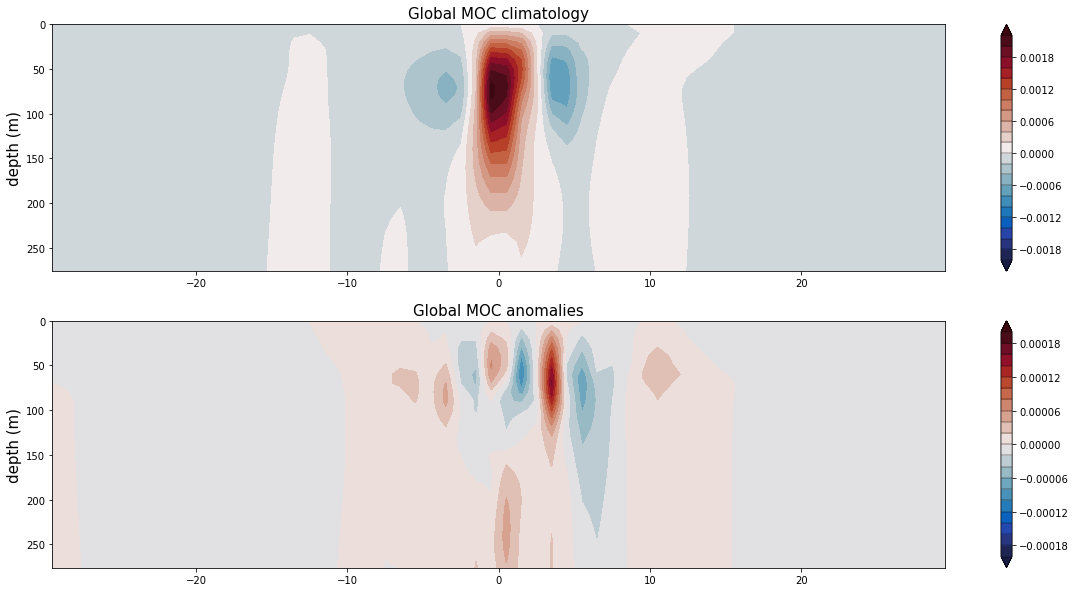

In [37]:
import cmocean
plt_wvel = wvel0[0,0:26,:,200:240].mean('lon')
plt_wvel_diff = wvel_diff[0,0:26,:,200:240].mean('lon')

fig, (ax0, ax1) = plt.subplots(2, 1,figsize=(20, 10))   # now you can reference the first object

cs0 = ax0.contourf(plt_wvel.lat[60:120],wz_in_m.isel(z_w_top=slice(0,26)),plt_wvel[:,60:120], levels=np.arange(-0.002, 0.0022, 0.0002), cmap=cmocean.cm.balance, extend='both')
cs1 = ax1.contourf(plt_wvel_diff.lat[60:120],wz_in_m.isel(z_w_top=slice(0,26)),plt_wvel_diff[:,60:120], levels=np.arange(-0.0002, 0.00022, 0.00002), cmap=cmocean.cm.balance, extend='both')
ax0.invert_yaxis()
ax1.invert_yaxis()


ax0.set_title('Global MOC climatology', fontsize=15)
ax1.set_title('Global MOC anomalies', fontsize=15)


ax0.set_ylabel('depth (m)',fontsize=15)
ax1.set_ylabel('depth (m)',fontsize=15)


fig.colorbar(cs0, ax=ax0, drawedges=True)
fig.colorbar(cs1,ax=ax1, drawedges=True)

In [74]:
heattc_series = heattc[70:100, 0, 0, :]
heattc_std = heattc_series.std(dim='time')
conf_lower = heattc_series.mean('time') - heattc_std
conf_upper = heattc_series.mean('time') + heattc_std

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [73]:
heat0_series = heat0[:, 0, 0, :]
heat0_std = heat0_series.std(dim='time')
conf_lower0 = heat0_series.mean('time') - heat0_std
conf_upper0 = heat0_series.mean('time') + heat0_std

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [75]:
heat_diff_series = heattc_series.copy(data=heattc_series.data - heat0_series.mean('time').data)
heat_diff_std = heat_diff_series.std(dim='time')
conf_lower_diff = heat_diff_series.mean('time') - heat_diff_std
conf_upper_diff = heat_diff_series.mean('time') + heat_diff_std


/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [81]:
def make_axes(plot_size):
    fig, ax1 = plt.subplots(figsize=plot_size)
    ax2 = ax1.twinx()

    # Use geocat.viz.util convenience function to add minor and major tick lines
    gvutil.add_major_minor_ticks(ax1, y_minor_per_major=5, labelsize=14)
    gvutil.add_major_minor_ticks(ax2, y_minor_per_major=5, labelsize=14)


    # Use geocat.viz.util convenience function to set axes tick values
    gvutil.set_axes_limits_and_ticks(ax1, ylim=(-1.9, 1.9), xlim = (-72,72))
    gvutil.set_axes_limits_and_ticks(ax2, ylim=(-0.06, 0.06))


    # Adjust which sides of the plot the tick marks are drawn for each axes
    ax1.tick_params('both', which='both', right=False)
    ax2.tick_params('both', which='both', bottom=False, top=False, left=False)
    return ax1, ax2

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


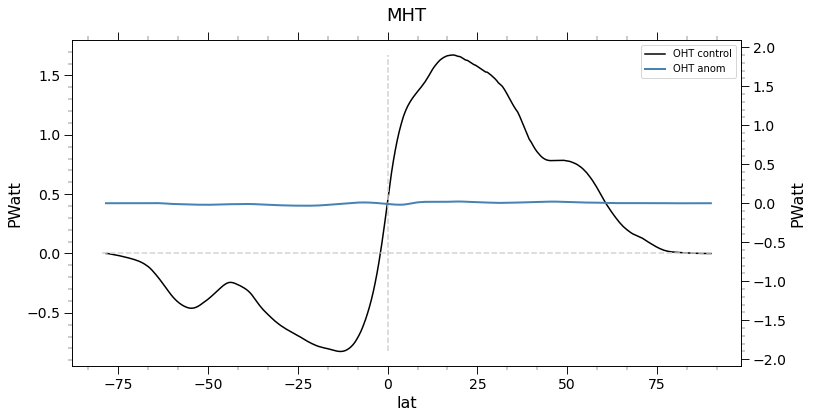

In [77]:
ax1, ax2 = make_axes((12, 6))
x = heattc.lat_aux_grid
cs1 = ax1.plot(x,heat0_series.mean('time'),color='black',label='OHT control')
ax1.plot(x,np.zeros(np.size(x)), color= "lightgrey", linestyle='--')
plt.vlines(0, -1.9, 1.9, linestyle='--', color='lightgrey')
#ax1.fill_between(x, conf_lower0, conf_upper0, color='lightblue', zorder=0)

cs2 = ax2.plot(x, heat_diff_series.mean('time'), color = "steelblue",  linewidth=2., label='OHT anom')
#ax2.fill_between(x, conf_lower_diff, conf_upper_diff, color='lightpink', zorder=0)

handles, labels = ax1.get_legend_handles_labels()
#handles2, labels2 = ax2.get_legend_handles_labels()

cs = cs1+cs2
labs = [l.get_label() for l in cs]
ax1.legend(cs, labs, loc=0)

gvutil.set_titles_and_labels(ax1, ylabel='PWatt', xlabel='lat',maintitle="MHT")
gvutil.set_titles_and_labels(ax2, ylabel='PWatt')
#plt.savefig("OHT_compare.pdf")

In [72]:
heat0_series

<xarray.DataArray 'N_HEAT' (time: 30, lat_aux_grid: 395)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    transport_components  |S256 b'Total'
    transport_regions     |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador Sea + GIN Sea + Arctic Ocean + Hudson Bay'
  * time                  (time) object 0301-02-01 00:00:00 ... 0330-02-01 00:00:00
  * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
Attributes:
    long_name:     Northward Heat Transport
    units:         Pwatt
    cell_methods:  time: mean

In [46]:
labels

['OHT control']

In [21]:
heat0_clm=heat0[:,0,0,:].mean('time')

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [22]:
heattc_clm = heattc[70:100,0,0,:].mean('time')

In [23]:
heat_diff = heat0_clm.copy(data=heattc_clm.data-heat0_clm.data)

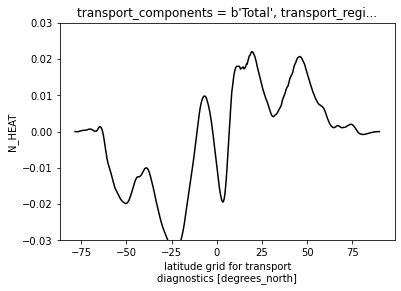

In [38]:
heat_diff.plot(ylim=(-0.03, 0.03),ls='-',color='black')